In [140]:
# Импорт библиотек
import re  # Для работы с регулярными выражениями
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [141]:
# Чтение датасета
df = pd.read_csv('data/data.csv', sep=';')
display(df.head())
display(df.info())

ID истории болезни Осн. диаг. при выписке МКБ10 (текст)  \
0  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   
1  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   
2  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   
3  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   
4  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   

  Заголовок документа            Кол. лаб. показатель  \
0  Общий анализ крови                 Лейкоциты (WBC)   
1  Общий анализ крови                Эритроциты (RBC)   
2  Общий анализ крови                Гемоглобин (HGB)   
3  Общий анализ крови                Гематокрит (HCT)   
4  Общий анализ крови  Средний объем эритроцита (MCV)   

   Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
0                      1.80                   10*9/л                  4:11   
1                      4.18                  10*12/л               3,8:5,7   
2                    120.00                      г/л               117:160   
3                     35.10                        %                 35:47   
4                     84.00                       фл                 80:99   

  Флаг нормы кол. показателя Кач. лаб. показатель Значение кач. показателя  \
0                      Пониж                  NaN                      NaN   
1                       Норм                  NaN                      NaN   
2                       Норм                  NaN                      NaN   
3                       Норм                  NaN                      NaN   
4                       Норм                  NaN                      NaN   

  Норма кач. показателя Пол Дата рождения пациента  
0                   NaN   Ж    1962-09-22 00:00:00  
1                   NaN   Ж    1962-09-22 00:00:00  
2                   NaN   Ж    1962-09-22 00:00:00  
3                   NaN   Ж    1962-09-22 00:00:00  
4                   NaN   Ж    1962-09-22 00:00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36297 entries, 0 to 36296
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ID истории болезни                    36297 non-null  object 
 1   Осн. диаг. при выписке МКБ10 (текст)  36297 non-null  object 
 2   Заголовок документа                   36297 non-null  object 
 3   Кол. лаб. показатель                  36236 non-null  object 
 4   Значение кол. показателя              36236 non-null  float64
 5   Ед. изм. кол. показателя              36236 non-null  object 
 6   Норма кол. показателя                 36236 non-null  object 
 7   Флаг нормы кол. показателя            36236 non-null  object 
 8   Кач. лаб. показатель                  7005 non-null   object 
 9   Значение кач. показателя              7005 non-null   object 
 10  Норма кач. показателя                 7005 non-null   object 
 11  Пол            

None

In [142]:
# Удаляем неинформативные столбцы (и так понятно что у нас документ -- ОАК)
print(f'Всего уникальных значений в Заголовке документа: {df["Заголовок документа"].nunique()}')
df = df.drop('Заголовок документа', axis=1)

Всего уникальных значений в Заголовке документа: 1


### Этап 1: Перекодировка пола в числовой признак

(перекодируем значение пола и добавим обработку неожиданных значений)

In [143]:
# Проверяем уникальные значения в столбце "Пол", чтобы убедиться в наличии только ожидаемых значений
unique_gender_values = df['Пол'].unique()
print(f"Уникальные значения в столбце 'Пол' перед преобразованием: {unique_gender_values}")

Уникальные значения в столбце 'Пол' перед преобразованием: ['Ж' 'М']


In [144]:
# Проверяем и обрабатываем значения
if set(unique_gender_values) <= {"Ж", "М"}:
    # Заменяем "Ж" на 0 и "М" на 1
    df['Пол'] = df['Пол'].map({"Ж": 0, "М": 1})
    print("Значения в столбце 'Пол' успешно заменены на числовые коды.")
else:
    # Если найдены другие значения, выводим предупреждение и не изменяем данные
    print("Предупреждение: найдены неожиданные значения в столбце 'Пол'. Проверьте данные перед продолжением.")

Значения в столбце 'Пол' успешно заменены на числовые коды.


### Этап 2: Расчет возраста пациентов



In [145]:
# Преобразование в формат даты с обработкой некорректных значений
df['Дата рождения пациента'] = pd.to_datetime(df['Дата рождения пациента'], errors='coerce')
print("Столбец 'Дата рождения пациента' успешно преобразован в формат даты.")

Столбец 'Дата рождения пациента' успешно преобразован в формат даты.


In [146]:
# Удаляем строки с некорректными датами рождения, если такие имеются
initial_row_count = df.shape[0]
df = df.dropna(subset=['Дата рождения пациента'])
dropped_rows = initial_row_count - df.shape[0]
print(f"Количество удаленных строк с некорректными датами рождения: {dropped_rows}")

Количество удаленных строк с некорректными датами рождения: 0


In [147]:
# Расчет возраста пациента
today = datetime.today()
df['Возраст'] = df['Дата рождения пациента'].apply(
    lambda birth_date: today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
)

In [148]:
# Удаление столбца "Дата рождения пациента"
df = df.drop(columns=['Дата рождения пациента'])
print("Столбец 'Дата рождения пациента' удален из данных после расчета возраста.")

Столбец 'Дата рождения пациента' удален из данных после расчета возраста.


### Этап 3: Обработка столбца 'Кол. лаб. показатель'

#### Обработка пропусков

In [149]:
# Выборка с пропущенными значениями по столбцу Кол. лаб. показатель
df_na = df[df["Кол. лаб. показатель"].isna()]
print(f'Всего строк с пропусками по показателям крови: {df_na.shape[0]}')
print(f'Комментарии: {df_na["Кач. лаб. показатель"].unique()}')
print(f'Причины в комментариях: {df_na["Значение кач. показателя"].unique()}')

Всего строк с пропусками по показателям крови: 61
Комментарии: ['Комментарий']
Причины в комментариях: ['сгусток крови!' 'Сгусток' 'сгусток крови'
 'тромбоциты по мазку 81х10*9/л' ' тромбоциты по мазку 23*10*9/л'
 'тромбоциты по мазку 21' 'формулу подсчитать невозможно'
 'тромбоциты пртоверены' 'встречаются микросгустки тромбоцитов' 'сгусток'
 'тромбоциты проверены по мазку'
 'шизоциты 4:1000 эритроцитов(№до 10:1000) ' 'нет на месте'
 'тромбоциты при подсчете по мазку 102' ',' 'ТРОМЮОЦИТЫ ПРОВЕРЕНЫ'
 'тромбоциты проверены' 'Тромбоциты проверены.' 'сгусток в крови'
 'тромбоциты по мазку 64*10*9/Л' 'Тромбоциты проверены\t' 'тромб.пров'
 'СОЭ - 7 мм/ч'
 'Лейкоциты после пересчета (без учета нормобластов) - 14,4х10х9/л. Тромбоциты проверены.  Моноцитоидные элементы отличаются полимрфизмом ядер,  наличием зернистости в цитоплазме , высоким ядерноцитоплазматическим соотношением .'
 'подсчитано 50 клеток, моноцитоидные элементы -16'
 'моноцитарные элементы с нуклеолами в ядре 63,5'
 'Тромбоци

Среди этих значений можно выделить те, которые нам говорят о некачественном и непригодном образце для определения показателей ОАК. Это, например, указания на наличие сгустка крови и другие причины, при которых подсчет клеток невозможен. Такие строки необходимо удалить:

In [150]:
# Определяем значения, при которых строки должны быть удалены
values_to_delete = [
    'сгусток крови!', 'Сгусток', 'сгусток крови', 'формулу подсчитать невозможно',
    'тромбоциты пртоверены', 'встречаются микросгустки тромбоцитов', 'сгусток',
    'тромбоциты проверены по мазку', 'нет на месте', 'сгусток в крови', ',',
    'ТРОМЮОЦИТЫ ПРОВЕРЕНЫ', 'тромбоциты проверены', 'Тромбоциты проверены.', 'Тромбоциты проверены\t', 'тромб.пров',
    'Тромбоциты проверены. Большинство бластных клеток представляет собой клетки крупных и средних размеров, с высоким ядерно-цитоплазматическим соотношением, уродливыми ядрами (неправильной формы ядра). хроматин сглаженный, встречаются нуклеолы. Цитоплазма у части клеток вакуолизированная.',
    'лейкоцитарную формулу подсчитать невозможно', 'подсчет л/ф невозможен',
    'моноцидоидные элементы с грубой структурой хроматина и остатаками нуклеол',
    'Тромбоциты проверены. Подсчет лейкоцитарной формулы невозможен из-за крайне низкого количества лейкоцитов крови.',
    'шизоциты 4:1000 эритроцитов(№до 10:1000) ',
    'Лейкоциты после пересчета (без учета нормобластов) - 14,4х10х9/л. Тромбоциты проверены.  Моноцитоидные элементы отличаются полимрфизмом ядер,  наличием зернистости в цитоплазме , высоким ядерноцитоплазматическим соотношением .',
    'моноцитарные элементы с нуклеолами в ядре 63,5',
    'Тромбоциты проверены. Большинство бластных клеток представляет собой клетки крупных и средних размеров, с высоким ядерно-цитоплазматическим соотношением, уродливыми ядрами (неправильной формы ядра). хроматин сглаженный, встречаются нуклеолы. Цитоплазма у части клеток вакуолизированная. ',
    'моноцитойдн элемент49', 'моноцитраные элементы - 60',
    'Тромбоциты проверены.  Подсчет лейкоцитарной формулы невозможен из-за  крайне низкого колическва лейкоцитов крови.'
]

In [151]:
# Удаляем строки с определенными значениями в "Значение кач. показателя"
df = df[~(df['Кол. лаб. показатель'].isna() & df['Значение кач. показателя'].isin(values_to_delete))]
deleted_rows = initial_row_count - df.shape[0]
print(f"Количество удаленных строк: {deleted_rows}")

Количество удаленных строк: 51


#### Восстанавливаем оставшеся значения пропусков:

In [152]:
# Оставшиеся пропуски по столбцу 'Кол. лаб. показатель'
print(f"Всего строк с пропуском по столбцу 'Кол. лаб. показатель': {df[df['Кол. лаб. показатель'].isna()].shape[0]}")
print(f"Причина этих пропусков: {df[df['Кол. лаб. показатель'].isna()]['Значение кач. показателя'].unique()}")

Всего строк с пропуском по столбцу 'Кол. лаб. показатель': 10
Причина этих пропусков: ['тромбоциты по мазку 81х10*9/л' ' тромбоциты по мазку 23*10*9/л'
 'тромбоциты по мазку 21' 'тромбоциты при подсчете по мазку 102'
 'тромбоциты по мазку 64*10*9/Л' 'СОЭ - 7 мм/ч'
 'подсчитано 50 клеток, моноцитоидные элементы -16'
 'бласты 59 ( моноцитоидные)' 'бласты - большая часть моноцитоидной формы'
 'подсчитано 50 клеток']


In [153]:
# Условие для выбора строк, где 'Значение кач. показателя' == 'тромбоциты по мазку 81х10*9/л'
condition = df['Значение кач. показателя'] == 'тромбоциты по мазку 81х10*9/л'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'Тромбоциты (PLT)'
df.loc[condition, 'Значение кол. показателя'] = 81
df.loc[condition, 'Ед. изм. кол. показателя'] = '10*9/л'

# Проверка изменений
df[condition]

ID истории болезни  \
2378  b36a2106-4308-11ed-ab5a-0050568844e6   

     Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
2378     Хронический лимфоцитарный лейкоз     Тромбоциты (PLT)   

      Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
2378                      81.0                   10*9/л                   NaN   

     Флаг нормы кол. показателя Кач. лаб. показатель  \
2378                        NaN          Комментарий   

           Значение кач. показателя Норма кач. показателя  Пол  Возраст  
2378  тромбоциты по мазку 81х10*9/л                     _    1       77

In [154]:
# Условие для выбора строк, где 'Значение кач. показателя' == ' тромбоциты по мазку 23*10*9/л'
condition = df['Значение кач. показателя'] == ' тромбоциты по мазку 23*10*9/л'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'Тромбоциты (PLT)'
df.loc[condition, 'Значение кол. показателя'] = 23
df.loc[condition, 'Ед. изм. кол. показателя'] = '10*9/л'

# Проверка изменений
df[condition]

ID истории болезни  \
5609  eebeb925-9f8e-11ec-ab54-0050568844e6   

     Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
5609             Другой уточненный лейкоз     Тромбоциты (PLT)   

      Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
5609                      23.0                   10*9/л                   NaN   

     Флаг нормы кол. показателя Кач. лаб. показатель  \
5609                        NaN          Комментарий   

            Значение кач. показателя Норма кач. показателя  Пол  Возраст  
5609   тромбоциты по мазку 23*10*9/л                     _    1       68

In [155]:
# Условие для выбора строк, где 'Значение кач. показателя' == 'тромбоциты по мазку 21'
condition = df['Значение кач. показателя'] == 'тромбоциты по мазку 21'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'Тромбоциты (PLT)'
df.loc[condition, 'Значение кол. показателя'] = 21
df.loc[condition, 'Ед. изм. кол. показателя'] = '10*9/л'

# Проверка изменений
df[condition]

ID истории болезни  \
5610  eebeb925-9f8e-11ec-ab54-0050568844e6   

     Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
5610             Другой уточненный лейкоз     Тромбоциты (PLT)   

      Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
5610                      21.0                   10*9/л                   NaN   

     Флаг нормы кол. показателя Кач. лаб. показатель Значение кач. показателя  \
5610                        NaN          Комментарий   тромбоциты по мазку 21   

     Норма кач. показателя  Пол  Возраст  
5610                     _    1       68

In [156]:
# Условие для выбора строк, где 'Значение кач. показателя' == 'тромбоциты при подсчете по мазку 102',
condition = df['Значение кач. показателя'] ==  'тромбоциты при подсчете по мазку 102'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'Тромбоциты (PLT)'
df.loc[condition, 'Значение кол. показателя'] = 102
df.loc[condition, 'Ед. изм. кол. показателя'] = '10*9/л'

# Проверка изменений
df[condition]

ID истории болезни  \
17789  7b9025cb-ae7c-11ec-ab54-0050568844e6   

      Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
17789             Другой уточненный лейкоз     Тромбоциты (PLT)   

       Значение кол. показателя Ед. изм. кол. показателя  \
17789                     102.0                   10*9/л   

      Норма кол. показателя Флаг нормы кол. показателя Кач. лаб. показатель  \
17789                   NaN                        NaN          Комментарий   

                   Значение кач. показателя Норма кач. показателя  Пол  \
17789  тромбоциты при подсчете по мазку 102                     _    0   

       Возраст  
17789       72

In [157]:
# Условие для выбора строк, где 'Значение кач. показателя' == 'тромбоциты по мазку 64*10*9/Л'
condition = df['Значение кач. показателя'] ==  'тромбоциты по мазку 64*10*9/Л'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'Тромбоциты (PLT)'
df.loc[condition, 'Значение кол. показателя'] = 64
df.loc[condition, 'Ед. изм. кол. показателя'] = '10*9/л'

# Проверка изменений
df[condition]

ID истории болезни  \
22833  268d2f6a-32ae-11ea-80c5-901b0e633689   

      Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
22833             Другой уточненный лейкоз     Тромбоциты (PLT)   

       Значение кол. показателя Ед. изм. кол. показателя  \
22833                      64.0                   10*9/л   

      Норма кол. показателя Флаг нормы кол. показателя Кач. лаб. показатель  \
22833                   NaN                        NaN          Комментарий   

            Значение кач. показателя Норма кач. показателя  Пол  Возраст  
22833  тромбоциты по мазку 64*10*9/Л                     _    0       86

In [158]:
# Условие для выбора строк, где 'Значение кач. показателя' == 'СОЭ - 7 мм/ч'
condition = df['Значение кач. показателя'] ==  'СОЭ - 7 мм/ч'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'СОЭ по Вестергрену'
df.loc[condition, 'Значение кол. показателя'] = 7
df.loc[condition, 'Ед. изм. кол. показателя'] = 'мм/час'

# Проверка изменений
df[condition]

ID истории болезни  \
25849  81f895b9-2ee2-11eb-80e0-901b0e633689   

      Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
25849             Другой миелоидный лейкоз   СОЭ по Вестергрену   

       Значение кол. показателя Ед. изм. кол. показателя  \
25849                       7.0                   мм/час   

      Норма кол. показателя Флаг нормы кол. показателя Кач. лаб. показатель  \
25849                   NaN                        NaN          Комментарий   

      Значение кач. показателя Норма кач. показателя  Пол  Возраст  
25849             СОЭ - 7 мм/ч                     _    1       50

In [159]:
# Условие для выбора строк, где 'Значение кач. показателя' == 'бласты 59 ( моноцитоидные)'
condition = df['Значение кач. показателя'] ==  'бласты 59 ( моноцитоидные)'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'Бласты (абс)'
df.loc[condition, 'Значение кол. показателя'] = 59
df.loc[condition, 'Ед. изм. кол. показателя'] = 'кол-во клеток'
df.loc[condition, 'Норма кол. показателя'] = '0:0'
df.loc[condition, 'Флаг нормы кол. показателя'] = 'Повыш'

# Проверка изменений
df[condition]

ID истории болезни  \
27365  72f64027-6cf5-11ea-80ce-901b0e63368b   

      Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
27365             Острый миелоидный лейкоз         Бласты (абс)   

       Значение кол. показателя Ед. изм. кол. показателя  \
27365                      59.0            кол-во клеток   

      Норма кол. показателя Флаг нормы кол. показателя Кач. лаб. показатель  \
27365                   0:0                      Повыш          Комментарий   

         Значение кач. показателя Норма кач. показателя  Пол  Возраст  
27365  бласты 59 ( моноцитоидные)                     _    0       61

In [160]:
# Условие для выбора строк, где 'Значение кач. показателя' == 'подсчитано 50 клеток'
condition = df['Значение кач. показателя'] ==  'подсчитано 50 клеток'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'Бласты (абс)'
df.loc[condition, 'Значение кол. показателя'] = 50
df.loc[condition, 'Ед. изм. кол. показателя'] = 'кол-во клеток'
df.loc[condition, 'Норма кол. показателя'] = '0:0'
df.loc[condition, 'Флаг нормы кол. показателя'] = 'Повыш'

# Проверка изменений
df[condition]

ID истории болезни  \
27708  4f87b4a4-4406-11ea-80c7-901b0e633688   

      Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
27708             Острый миелоидный лейкоз         Бласты (абс)   

       Значение кол. показателя Ед. изм. кол. показателя  \
27708                      50.0            кол-во клеток   

      Норма кол. показателя Флаг нормы кол. показателя Кач. лаб. показатель  \
27708                   0:0                      Повыш          Комментарий   

      Значение кач. показателя Норма кач. показателя  Пол  Возраст  
27708     подсчитано 50 клеток                     _    0       65

In [161]:
# Условие для выбора строк, где 'Значение кач. показателя' == 'подсчитано 50 клеток, моноцитоидные элементы -16'
condition = df['Значение кач. показателя'] ==  'подсчитано 50 клеток, моноцитоидные элементы -16'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'Бласты (абс)'
df.loc[condition, 'Значение кол. показателя'] = 50
df.loc[condition, 'Ед. изм. кол. показателя'] = 'кол-во клеток'
df.loc[condition, 'Норма кол. показателя'] = '0:0'
df.loc[condition, 'Флаг нормы кол. показателя'] = 'Повыш'

# Проверка изменений
df[condition]

ID истории болезни  \
27047  72f64027-6cf5-11ea-80ce-901b0e63368b   

      Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
27047             Острый миелоидный лейкоз         Бласты (абс)   

       Значение кол. показателя Ед. изм. кол. показателя  \
27047                      50.0            кол-во клеток   

      Норма кол. показателя Флаг нормы кол. показателя Кач. лаб. показатель  \
27047                   0:0                      Повыш          Комментарий   

                               Значение кач. показателя Норма кач. показателя  \
27047  подсчитано 50 клеток, моноцитоидные элементы -16                     _   

       Пол  Возраст  
27047    0       61

In [162]:
# Условие для выбора строк, где 'Значение кач. показателя' == 'бласты - большая часть моноцитоидной формы'
condition = df['Значение кач. показателя'] ==  'бласты - большая часть моноцитоидной формы'

# Заполнение значений в соответствующих столбцах
df.loc[condition, 'Кол. лаб. показатель'] = 'Бласты (абс)'
df.loc[condition, 'Значение кол. показателя'] = "1"
df.loc[condition, 'Ед. изм. кол. показателя'] = 'кол-во клеток'
df.loc[condition, 'Норма кол. показателя'] = '0:0'
df.loc[condition, 'Флаг нормы кол. показателя'] = 'Повыш'

# Проверка изменений
df[condition]

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_19244\3272911212.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[condition, 'Значение кол. показателя'] = "1"


ID истории болезни  \
27366  72f64027-6cf5-11ea-80ce-901b0e63368b   

      Осн. диаг. при выписке МКБ10 (текст) Кол. лаб. показатель  \
27366             Острый миелоидный лейкоз         Бласты (абс)   

      Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
27366                        1            кол-во клеток                   0:0   

      Флаг нормы кол. показателя Кач. лаб. показатель  \
27366                      Повыш          Комментарий   

                         Значение кач. показателя Норма кач. показателя  Пол  \
27366  бласты - большая часть моноцитоидной формы                     _    0   

       Возраст  
27366       61

In [163]:
# Оставшиеся пропуски по столбцу 'Кол. лаб. показатель'
print(f"Всего строк с пропуском по столбцу 'Кол. лаб. показатель': {df[df['Кол. лаб. показатель'].isna()].shape[0]}")

Всего строк с пропуском по столбцу 'Кол. лаб. показатель': 0


#### Унификация показателей 

Цель: Объединить одинаковые показатели, которые представлены разными наименованиями и единицами, чтобы сделать данные более унифицированными и удобными для анализа.

In [164]:
# Вывод всех уникальных значений в колонке "Кол. лаб. показатель"
unique_lab_indicators = df['Кол. лаб. показатель'].unique()
print("Уникальные значения в колонке 'Кол. лаб. показатель':")
print(unique_lab_indicators)

Уникальные значения в колонке 'Кол. лаб. показатель':
['Лейкоциты (WBC)' 'Эритроциты (RBC)' 'Гемоглобин (HGB)'
 'Гематокрит (HCT)' 'Средний объем эритроцита (MCV)'
 'Среднее содержание гемоглобина в эритроците (MCH)'
 'Средняя концентрация гемоглобина в эритроците (MCHC)' 'Тромбоциты (PLT)'
 'Нейтрофилы, относительное количество (NE%)'
 'Лимфоциты, относительное количество (LY%)'
 'Нейтрофилы, абсолютное количество (NE#)'
 'Лимфоциты, абсолютное количество (LY#)'
 'Смешанная фракция, абсолютное количество (MXD#)'
 'Смешанная фракция, относительное количество (MXD%)'
 'Ширина распределения эритроцитов по объему, коэффициент вариации (RDW-CV)'
 'Ширина распределения эритроцитов по объему, стандартное отклонение (RDW-SD)'
 'Ширина распределения эритроцитов по объему (RDW)' 'Тромбокрит (PCT)'
 'Средний объем тромбоцита (MPV)' 'Ширина распределения тромбоцитов (PDW)'
 'Моноциты, относительное количество (MO%)'
 'Эозинофилы, относительное количество (EO%)'
 'Базофилы, относительное количеств

In [165]:
# Создаем словарь для унификации показателей и приведения их к общему названию
unification_dict = {
    'Лейкоциты (WBC)': 'Лейкоциты (WBC)',
    'WBC': 'Лейкоциты (WBC)',
    'Общее количество лейкоцитов (WBC)': 'Лейкоциты (WBC)',
    'Лейкоциты': 'Лейкоциты (WBC)', # проверено
    
    'Эритроциты (RBC)': 'Эритроциты (RBC)',
    'RBC': 'Эритроциты (RBC)',
    'Общее количество эритроцитов (RBC)': 'Эритроциты (RBC)',
    'Эритроциты': 'Эритроциты (RBC)', # проверено
    
    'Гемоглобин (HGB)': 'Гемоглобин (HGB)',
    'HGB': 'Гемоглобин (HGB)',
    'Гемоглобин': 'Гемоглобин (HGB)', # проверено
    
    'Гематокрит (HCT)': 'Гематокрит (HCT)',
    'HCT': 'Гематокрит (HCT)',
    'Гематокрит': 'Гематокрит (HCT)', # проверено

    'Тромбоциты (PLT)': 'Тромбоциты (PLT)',
    'PLT': 'Тромбоциты (PLT)',
    'Тромбоциты': 'Тромбоциты (PLT)', # проверено
    
    'Средний объем эритроцита (MCV)': 'Средний объем эритроцита (MCV)',
    'MCV': 'Средний объем эритроцита (MCV)',
    'Средний объем эритроцита': 'Средний объем эритроцита (MCV)', # проверено
    
    'Среднее содержание гемоглобина в эритроците (MCH)': 'Среднее содержание гемоглобина в эритроците (MCH)',
    'MCH': 'Среднее содержание гемоглобина в эритроците (MCH)',
    'Среднее содержание гемоглобина в эритроците': 'Среднее содержание гемоглобина в эритроците (MCH)', # проверено
    
    'Средняя концентрация гемоглобина в эритроците (MCHC)': 'Средняя концентрация гемоглобина в эритроците (MCHC)',
    'MCHC': 'Средняя концентрация гемоглобина в эритроците (MCHC)',
    'Средняя концентрация гемоглобина в эритроците': 'Средняя концентрация гемоглобина в эритроците (MCHC)', # проверено

    'Средний объем тромбоцита (MPV)': 'Средний объем тромбоцита (MPV)',
    'MPV': 'Средний объем тромбоцита (MPV)',
    'MPV ': 'Средний объем тромбоцита (MPV)',
    'MPV (Средний объём тромбоцитов)': 'Средний объем тромбоцита (MPV)',
    'Средний объём тромбоцитов': 'Средний объем тромбоцита (MPV)',
    'Средний объём тромбоцита': 'Средний объем тромбоцита (MPV)', 
    'Средний объем тромбоцита': 'Средний объем тромбоцита (MPV)', # проверено

    'Тромбокрит (PCT)': 'Тромбокрит (PCT)',
    'PCT': 'Тромбокрит (PCT)',
    'Тромбокрит': 'Тромбокрит (PCT)', # проверено
    
    'Ширина распределения эритроцитов по объему (RDW)': 'Распределение эритроцитов по объему (RDW)',
    'Ширина распределения эритроцитов': 'Распределение эритроцитов по объему (RDW)',
    'RDW': 'Распределение эритроцитов по объему (RDW)', # проверено
    'Ширина распределения эритроцитов (RDW)': 'Распределение эритроцитов по объему (RDW)',

    'Ширина распределения эритроцитов по объему, коэффициент вариации (RDW-CV)': 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)',
    'Ширина распределения эритроцитов по объему, коэффициент вариации': 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)',
    'RDW-CV': 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)',
    'RDW-CV ': 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)', # проверено

    'Ширина распределения эритроцитов по объему, стандартное отклонение (RDW-SD)': 'Распределение эритроцитов по объему, стандартное отклонение (RDW-SD)',
    'Ширина распределения эритроцитов по объему, стандартное отклонение': 'Распределение эритроцитов по объему, стандартное отклонение (RDW-SD)', 
    'Ширина распределения эритроцитов, стандартное отклонение (RDW-SD)': 'Распределение эритроцитов по объему, стандартное отклонение (RDW-SD)',
    'RDW-SD': 'Распределение эритроцитов по объему, стандартное отклонение (RDW-SD)', # проверено

    'Ширина распределения тромбоцитов (PDW)': 'Распределение тромбоцитов по объему (PDW)',
    'Ширина распределения тромбоцитов': 'Распределение тромбоцитов по объему (PDW)',
    'Ширина распределения тромбоцитов по объему': 'Распределение тромбоцитов по объему (PDW)',
    'PDW': 'Распределение тромбоцитов по объему (PDW)', # проверено

    'Скорость оседания эритроцитов (СОЭ) по Вестергрену': 'СОЭ по Вестергрену',
    'СОЭ Вест.': 'СОЭ по Вестергрену',
    'СОЭ': 'СОЭ по Вестергрену', # проверено
    
    'Нейтрофилы, относительное количество (NE%)': 'Нейтрофилы, относительное количество (NE%)',
    'Относительное количество нейтрофилов (NE%)': 'Нейтрофилы, относительное количество (NE%)',
    'NE%': 'Нейтрофилы, относительное количество (NE%)',
    'Нейтрофилы %': 'Нейтрофилы, относительное количество (NE%)',
    'Нейтрофилы, относительное количество': 'Нейтрофилы, относительное количество (NE%)', # проверено
    
    'Нейтрофилы, абсолютное количество (NE#)': 'Нейтрофилы, абсолютное количество (NE#)',
    'Абсолютное количество нейтрофилов (NE#)': 'Нейтрофилы, абсолютное количество (NE#)',
    'Нейтрофилы #': 'Нейтрофилы, абсолютное количество (NE#)',
    'Нейтрофилы, абсолютное количество': 'Нейтрофилы, абсолютное количество (NE#)', # проверено
    
    'Лимфоциты, относительное количество (LY%)': 'Лимфоциты, относительное количество (LY%)',
    'Относительное количество лимфоцитов (LY%)': 'Лимфоциты, относительное количество (LY%)',
    'LY%': 'Лимфоциты, относительное количество (LY%)',
    'Лимфоциты %': 'Лимфоциты, относительное количество (LY%)',
    'Лимфоциты, относительное количество': 'Лимфоциты, относительное количество (LY%)', # проверено
    
    'Лимфоциты, абсолютное количество (LY#)': 'Лимфоциты, абсолютное количество (LY#)',
    'Абсолютное количество лимфоцитов (LY#)': 'Лимфоциты, абсолютное количество (LY#)',
    'Лимфоциты #': 'Лимфоциты, абсолютное количество (LY#)',
    'Лимфоциты, абсолютное количество': 'Лимфоциты, абсолютное количество (LY#)', # проверено

    'Моноциты, относительное количество (MO%)': 'Моноциты, относительное количество (MO%)',
    'Моноциты, относительное количество': 'Моноциты, относительное количество (MO%)',
    'Относительное количество моноцитов (MO%)': 'Моноциты, относительное количество (MO%)',
    'MO%': 'Моноциты, относительное количество (MO%)',
    'Моноциты %': 'Моноциты, относительное количество (MO%)', # проверено

    'Моноциты, абсолютное количество (MO#)': 'Моноциты, абсолютное количество (MO#)',
    'Моноциты, абсолютное количество': 'Моноциты, абсолютное количество (MO#)',
    'Абсолютное количество моноцитов (MO#)': 'Моноциты, абсолютное количество (MO#)',
    'Моноциты #': 'Моноциты, абсолютное количество (MO#)', # проверено

    'Эозинофилы, относительное количество (EO%)': 'Эозинофилы, относительное количество (EO%)',
    'Эозинофилы, относительное количество': 'Эозинофилы, относительное количество (EO%)',
    'Относительное количество эозинофилов (EO%)': 'Эозинофилы, относительное количество (EO%)',
    'Эозинофилы %': 'Эозинофилы, относительное количество (EO%)',
    'EO%': 'Эозинофилы, относительное количество (EO%)', # проверено

    'Эозинофилы, абсолютное количество (EO#)': 'Эозинофилы, абсолютное количество (EO#)',
    'Эозинофилы, абсолютное количество': 'Эозинофилы, абсолютное количество (EO#)',
    'Абсолютное количество эозинофилов (EO#)': 'Эозинофилы, абсолютное количество (EO#)',
    'Эозинофилы # ': 'Эозинофилы, абсолютное количество (EO#)',
    'Эозинофилы #': 'Эозинофилы, абсолютное количество (EO#)', # проверено

    'Базофилы, относительное количество (BA%)': 'Базофилы, относительное количество (BA%)',
    'Базофилы, относительное количество': 'Базофилы, относительное количество (BA%)',
    'Относительное количество базофилов (BA%)': 'Базофилы, относительное количество (BA%)',
    'Базофилы %': 'Базофилы, относительное количество (BA%)',
    'BA%': 'Базофилы, относительное количество (BA%)', # проверено

    'Базофилы, абсолютное количество (BA#)': 'Базофилы, абсолютное количество (BA#)',
    'Абсолютное количество базофилов (BA#)': 'Базофилы, абсолютное количество (BA#)',
    'Базофилы, абсолютное количество': 'Базофилы, абсолютное количество (BA#)',
    'Базофилы #': 'Базофилы, абсолютное количество (BA#)',
    'Базофилы # ': 'Базофилы, абсолютное количество (BA#)', # проверено
    
    'Смешанная фракция, относительное количество (MXD%)': 'Смешанная фракция, относительное количество (MXD%)',
    'Смешанная фракция, относительное количество': 'Смешанная фракция, относительное количество (MXD%)',
    'MXD%': 'Смешанная фракция, относительное количество (MXD%)', # проверено
        
    'Смешанная фракция, абсолютное количество (MXD#)': 'Смешанная фракция, абсолютное количество (MXD#)',
    'Смешанная фракция, абсолютное количество': 'Смешанная фракция, абсолютное количество (MXD#)',
    'MXD#': 'Смешанная фракция, абсолютное количество (MXD#)',
    'MXD# ': 'Смешанная фракция, абсолютное количество (MXD#)', # проверено

    'Нормобласты %': 'Нормобласты, относительное количество (%)', # проверено
    'Нормобласты #': 'Нормобласты, абсолютное количество (#)', # проверено
    'Ретикулоциты %': 'Ретикулоциты, абсолютное количество (#)', # проверено
    'Ретикулоциты кол-во': 'Ретикулоциты, абсолютное количество (#)', # проверено
    'RET%': 'Ретикулоциты, относительное количество (%)', # проверено
    'Цветовой показатель': 'Цветовой показатель', 
    
    'Палочкоядерные': 'Палочкоядерные нейтрофилы (%)',
    'Сегментоядерные': 'Сегментоядерные нейтрофилы (%)',
    'Базофилы': 'Базофилы (лейкоцитарная формула, %)',
    'Лимфоциты': 'Лимфоциты (лейкоцитарная формула, %)',
    'Моноциты': 'Моноциты (лейкоцитарная формула, %)',
    'Эозинофилы': 'Эозинофилы (лейкоцитарная формула, %)',
    'Плазматические клетки': 'Плазматические клетки',
    'Плазматич. клетки': 'Плазматические клетки',
    'Миелоциты': 'Миелоциты (лейкоцитарная формула, %)',
    'Промиелоциты': 'Промиелоциты (лейкоцитарная формула, %)',
    'Пролимфоциты': 'Пролимфоциты (лейкоцитарная формула, %)',
    'Нормобласты': 'Нормобласты',
    'P-LCR': 'P-LCR',
}


In [166]:
# Применяем унификацию названий
df['Кол. лаб. показатель'] = df['Кол. лаб. показатель'].replace(unification_dict)
print("Наименования показателей успешно унифицированы.")

Наименования показателей успешно унифицированы.


In [167]:
new_unique_lab_indicators = df['Кол. лаб. показатель'].unique()
print("Новые уникальные значения в колонке 'Кол. лаб. показатель':")
print(new_unique_lab_indicators)

Новые уникальные значения в колонке 'Кол. лаб. показатель':
['Лейкоциты (WBC)' 'Эритроциты (RBC)' 'Гемоглобин (HGB)'
 'Гематокрит (HCT)' 'Средний объем эритроцита (MCV)'
 'Среднее содержание гемоглобина в эритроците (MCH)'
 'Средняя концентрация гемоглобина в эритроците (MCHC)' 'Тромбоциты (PLT)'
 'Нейтрофилы, относительное количество (NE%)'
 'Лимфоциты, относительное количество (LY%)'
 'Нейтрофилы, абсолютное количество (NE#)'
 'Лимфоциты, абсолютное количество (LY#)'
 'Смешанная фракция, абсолютное количество (MXD#)'
 'Смешанная фракция, относительное количество (MXD%)'
 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)'
 'Распределение эритроцитов по объему, стандартное отклонение (RDW-SD)'
 'Распределение эритроцитов по объему (RDW)' 'Тромбокрит (PCT)'
 'Средний объем тромбоцита (MPV)'
 'Распределение тромбоцитов по объему (PDW)'
 'Моноциты, относительное количество (MO%)'
 'Эозинофилы, относительное количество (EO%)'
 'Базофилы, относительное количество (BA%)'
 '

#### Удаление неинформативных значений

**СОЭ по Панченкову** - это устаревший метод определения СОЭ, который было решено удалить. Метод Вестергрена одобрен в качестве эталонного Международным комитетом по стандартизации в гематологии (ICSH) и регулируется стандартом Института клинических и лабораторных стандартов (CLSI). 

Показатель **смешанной фракции или MXD** отражает суммарно долю базофилов, эозинофилов и моноцитов. И так как эти показатели у нас есть отдельно, то суммарный возможно будет с ними коррелировать, в связи с чем его следует удалить. 

Удалим также P-LCR, который не очень специфичен в дифф. диагностике лейкозов с другими заболеваниями

In [168]:
# Список значений для удаления
values_to_remove = ['СОЭ Панч.','СОЭ по Панченкову', 'MXD', 'P-LCR',
                    'Смешанная фракция, абсолютное количество (MXD#)', 
                    'Смешанная фракция, относительное количество (MXD%)'] 

# Удаление строк, где "Кол. лаб. показатель" имеет одно из значений в списке
df = df[~df['Кол. лаб. показатель'].isin(values_to_remove)]
print("Строки с указанными значениями удалены.")

Строки с указанными значениями удалены.


In [169]:
print(df['Кол. лаб. показатель'].value_counts())

Кол. лаб. показатель
Тромбоциты (PLT)                                                        1622
Эритроциты (RBC)                                                        1619
Средний объем эритроцита (MCV)                                          1619
Гематокрит (HCT)                                                        1619
Среднее содержание гемоглобина в эритроците (MCH)                       1619
Гемоглобин (HGB)                                                        1619
Средняя концентрация гемоглобина в эритроците (MCHC)                    1619
Лейкоциты (WBC)                                                         1616
Лимфоциты, относительное количество (LY%)                               1470
Лимфоциты, абсолютное количество (LY#)                                  1470
Нейтрофилы, относительное количество (NE%)                              1332
Нейтрофилы, абсолютное количество (NE#)                                 1319
Средний объем тромбоцита (MPV)                         

### Этап 4: Обработка значений в столбце 'Ед. изм. кол. показателя'

In [170]:
# Смотрим значения в столбце
print(df['Ед. изм. кол. показателя'].value_counts())

Ед. изм. кол. показателя
%                14518
10*9/л            8461
фл                3666
г/л               2528
10*12/л           1619
пг                1619
_                 1011
г/дл               715
мм/час             569
fL                 136
FL                  59
кол-во клеток        4
Name: count, dtype: int64


In [171]:
# Фильтрация строк, где "Ед. изм. кол. показателя" равно "г/дл"
gdl_df = df[df['Ед. изм. кол. показателя'] == 'г/дл']

In [172]:
# Подсчет количества для каждого значения "г/дл" в "Кол. лаб. показатель"
count_per_lab = gdl_df['Кол. лаб. показатель'].value_counts()
count_per_lab

Кол. лаб. показатель
Средняя концентрация гемоглобина в эритроците (MCHC)    715
Name: count, dtype: int64

In [173]:
# Фильтрация строк, где "Ед. изм. кол. показателя" равно "г/л"
gl_df = df[df['Ед. изм. кол. показателя'] == 'г/л']

In [174]:
# Подсчет количества для каждого значения "г/л" в "Кол. лаб. показатель"
count_per_lab = gl_df['Кол. лаб. показатель'].value_counts()
count_per_lab

Кол. лаб. показатель
Гемоглобин (HGB)                                        1619
Средняя концентрация гемоглобина в эритроците (MCHC)     904
Распределение тромбоцитов по объему (PDW)                  5
Name: count, dtype: int64

нужно перевести г/дл в г/л, т.к. в интернете написано, что (MCHC) тоже измеряется в г/л

In [175]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Средняя концентрация гемоглобина в эритроците (MCHC)'
# и 'Ед. изм. кол. показателя' равен 'г/дл'
mask_hb = (df['Кол. лаб. показатель'] == 'Средняя концентрация гемоглобина в эритроците (MCHC)') & (df['Ед. изм. кол. показателя'] == 'г/дл')

# Умножаем значения в столбце 'Значение кол. показателя' на 10 для выбранных строк
df.loc[mask_hb, 'Значение кол. показателя'] *= 10

# Обновляем единицу измерения на 'г/л' для выбранных строк
df.loc[mask_hb, 'Ед. изм. кол. показателя'] = 'г/л'

print("Единицы измерения для показателя 'Средняя концентрация гемоглобина в эритроците (MCHC)' успешно преобразованы в г/л.")


Единицы измерения для показателя 'Средняя концентрация гемоглобина в эритроците (MCHC)' успешно преобразованы в г/л.


In [176]:
# Исправляем обозначения единиц для других показателей
# Пример: приводим FL и фл к одному обозначению
df['Ед. изм. кол. показателя'] = df['Ед. изм. кол. показателя'].replace({'FL': 'фл', 'fL': 'фл', 'фЛ': 'фл'})
print("Единицы измерения успешно унифицированы для обозначения 'фл'.")

Единицы измерения успешно унифицированы для обозначения 'фл'.


In [177]:
print(df['Ед. изм. кол. показателя'].value_counts())

Ед. изм. кол. показателя
%                14518
10*9/л            8461
фл                3861
г/л               3243
10*12/л           1619
пг                1619
_                 1011
мм/час             569
кол-во клеток        4
Name: count, dtype: int64


### Этап 5: Обработка значений в столбце 'Норма кол. показателя'

Приводим нормы показателей к стандартным по возрасту и полу

In [178]:
print(df['Норма кол. показателя'].value_counts())

Норма кол. показателя
18:44          2135
45:72          2011
80:99          1604
150:450        1540
27:38          1530
               ... 
35:48             1
17:63,8           1
0,59:2,07         1
Общая норма       1
39,0:52,0         1
Name: count, Length: 115, dtype: int64


In [179]:
# Функция для вывода необходимой сводной информации
def norm_info(value):
    '''
    Функция принимает на вход одно из значений столбца 'Кол. лаб. показатель',
    то есть тот или иной параметр ОАК и выводит сводную инфу, связанную с ним
    '''
    df_value = df[df['Кол. лаб. показатель'] == value]
    norm_unique = df_value['Норма кол. показателя'].unique()
    print(f"Уникальные значения в столбце 'Норма кол. показателя' для показателя {value}:")
    print(norm_unique)

    measure_unique = df_value['Ед. изм. кол. показателя'].unique()
    print(f"Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя {value}:")
    print(measure_unique)

    value_result= df_value['Значение кол. показателя'].unique()
    print(f"Уникальные значения в столбце 'Значение кол. показателя' для показателя {value}:")
    print(value_result)

    print(f"Всего строк со значением {value}: {df[df['Кол. лаб. показатель'] == value].shape[0]}")

In [180]:
norm_info('Цветовой показатель')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Цветовой показатель:
['0,8:1,05' '0,85:1,15' '_' '0,8:1,5' '0,80:1,05' '0.80:1.05' '0.8:1.05']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Цветовой показатель:
['_']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Цветовой показатель:
[0.9 0.89 0.85 0.77 0.83 0.88 0.87 0.86 0.72 0.91 0.95 0.57 0.94 0.92 1.31
 1.24 1.28 1.35 0.84 0.82 0.93 0.7 0.74 0.76 0.68 0.75 0.71 0.65 1.04 1.03
 1.02 1.06 0.78 1.1 1.01 0.79 0.98 0.8 0.81 0.96 1.11 1.08 1.16 0.99 1.15
 1.12 1.0 0.62 1.14 1.2 0.55 0.73 0.64 0.63 0.6 0.49 1.29 0.61 0.56 0.59
 0.69 0.66 1.05 1.17 0.58 1.25 1.21 1.27 1.23 1.22 0.97 1.19]
Всего строк со значением Цветовой показатель: 832


In [181]:
# Заменяем значения в столбце "Норма кол. показателя" на "0.85:1.05" для строк, где "Кол. лаб. показатель" равен "Цветовой показатель"
df.loc[df['Кол. лаб. показатель'] == 'Цветовой показатель', 'Норма кол. показателя'] = '0.85:1.00'

# Проверка результата
print("Измененные значения в столбце 'Норма кол. показателя' для 'Цветовой показатель':")
print(df[df['Кол. лаб. показатель'] == 'Цветовой показатель']['Норма кол. показателя'].unique())

Измененные значения в столбце 'Норма кол. показателя' для 'Цветовой показатель':
['0.85:1.00']


In [182]:
norm_info('Гемоглобин (HGB)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Гемоглобин (HGB):
['117:160' '132:180' '117:180' '117:140' '114:154' '132:160' '122:168']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Гемоглобин (HGB):
['г/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Гемоглобин (HGB):
[120.0 109.0 118.0 96.0 101.0 119.0 111.0 72.0 121.0 104.0 113.0 106.0
 81.0 90.0 145.0 43.0 99.0 128.0 63.0 64.0 68.0 60.0 115.0 55.0 51.0 47.0
 162.0 91.0 82.0 130.0 103.0 122.0 168.0 172.0 163.0 181.0 158.0 125.0
 105.0 134.0 151.0 57.0 73.0 48.0 69.0 129.0 126.0 74.0 97.0 83.0 92.0
 89.0 107.0 154.0 133.0 142.0 153.0 143.0 66.0 87.0 127.0 65.0 131.0 178.0
 169.0 160.0 56.0 84.0 78.0 94.0 108.0 155.0 139.0 85.0 135.0 117.0 53.0
 112.0 80.0 100.0 61.0 76.0 123.0 124.0 116.0 98.0 75.0 144.0 93.0 86.0
 141.0 59.0 88.0 67.0 114.0 79.0 102.0 105.7 136.0 104.7 150.0 62.0 156.0
 95.0 146.0 37.0 34.0 45.0 54.0 38.0 50.0 42.0 41.0 77.0 110.0 46.0 36.0

In [183]:
# Норма взята с сайта: https://gemotest.ru/info/spravochnik/analizy/gemoglobin/
def get_hgb_norm(age, gender):
    """Возвращает норму гемоглобина в зависимости от возраста и пола."""
    if age < 18:
        # Норма для детей
        if age == 0:  # Возраст < 1 месяца (младенцы)
            return "152:235"
        elif 1 <= age <= 13 / 365:  # 2–13 дней
            return "150:240"
        elif 14 / 365 <= age <= 23 / 365:  # 14–23 дня
            return "127:187"
        elif 24 / 365 <= age <= 30 / 365:  # 24–30 дней
            return "103:179"
        elif age < 2 / 12:  # 1 месяц
            return "90:166"
        elif age < 3 / 12:  # 2 месяца
            return "92:150"
        elif age < 4 / 12:  # 3 месяца
            return "96:135"
        elif age < 5 / 12:  # 4 месяца
            return "96:135"
        elif age < 8 / 12:  # 5–7 месяцев
            return "101:132"
        elif age < 11 / 12:  # 8–10 месяцев
            return "105:135"
        elif age < 1:  # 11 месяцев
            return "107:131"
        elif age < 5:  # 12 месяцев — 4 года
            return "108:132"
        elif age < 10:  # 5–9 лет
            return "111:143"
        elif age < 12:  # 10–11 лет
            return "119:147"
        elif age < 15:  # 12–14 лет
            if gender == 1:  # Мальчики
                return "120:160"
            else:  # Девочки
                return "115:150"
        elif age < 18:  # 15–17 лет
            if gender == 1:  # Юноши
                return "117:166"
            else:  # Девушки
                return "117:153"
    else:
        # Норма для взрослых
        if gender == 1:  # Мужчины
            if 18 <= age <= 44:
                return "132:173"
            elif 45 <= age <= 64:
                return "131:172"
            else:  # От 65 лет
                return "126:174"
        else:  # Женщины
            if 18 <= age <= 44:
                return "117:155"
            elif 45 <= age <= 64:
                return "117:160"
            else:  # От 65 лет
                return "117:161"

In [184]:
# Применяем функцию для строк, где 'Кол. лаб. показатель' равно 'Гемоглобин (HGB)'
mask_hgb = df['Кол. лаб. показатель'] == 'Гемоглобин (HGB)'
df.loc[mask_hgb, 'Норма кол. показателя'] = df[mask_hgb].apply(lambda row: get_hgb_norm(row['Возраст'], row['Пол']), axis=1)

In [185]:
# Проверка результата
print("Установлены нормы гемоглобина для показателя 'Гемоглобин (HGB)'.")
print(df[mask_hgb][['Возраст', 'Пол', 'Норма кол. показателя']])

Установлены нормы гемоглобина для показателя 'Гемоглобин (HGB)'.
       Возраст  Пол Норма кол. показателя
2           62    0               117:160
18          62    0               117:160
48          62    0               117:160
78          62    0               117:160
106         62    0               117:160
...        ...  ...                   ...
36170       42    1               132:173
36197       42    1               132:173
36219       42    1               132:173
36246       42    1               132:173
36268       10    1               119:147

[1619 rows x 3 columns]


In [186]:
norm_info('Гематокрит (HCT)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Гематокрит (HCT):
['35:47' '39:52' '35:52' '34:46' '35,0:47,0' '30.0:49.5' '39,0:52,0']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Гематокрит (HCT):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Гематокрит (HCT):
[35.1 33.2 36.3 30.2 34.3 35.4 31.8 22.9 37.3 32.6 31.5 23.8 34.9 26.5
 31.6 35.0 45.4 13.0 31.9 40.6 18.0 19.0 19.6 32.3 34.4 35.5 16.0 14.0
 57.4 27.4 24.8 40.8 31.1 36.2 56.7 61.8 59.6 66.8 29.8 57.9 39.1 32.7
 32.5 47.2 53.4 25.0 30.4 20.8 35.6 33.3 24.0 21.7 27.0 22.0 23.0 22.6
 26.1 29.4 41.1 36.8 41.6 45.6 42.1 33.9 26.6 35.2 18.7 25.6 29.6 34.8
 18.3 38.2 54.4 21.0 29.0 30.0 50.6 46.6 28.0 17.0 33.0 19.2 22.8 23.4
 31.0 21.8 46.2 43.9 36.0 43.0 40.0 33.7 17.1 37.0 28.3 23.2 20.1 32.0
 32.4 24.1 34.0 37.9 38.0 39.0 42.0 40.7 40.4 39.9 23.1 37.2 33.1 37.8
 28.8 45.9 25.7 31.4 28.2 30.8 28.6 33.8 30.5 31.3 32.8 34.2 33.6 33.4
 25.8 19.5 40.5 35

In [187]:
# норма взята с сайта: https://gemotest.ru/info/spravochnik/analizy/gematokrit/
def get_hct_norm(age, gender):
    """Возвращает норму гематокрита в зависимости от возраста и пола."""
    if age < 18:
        # Норма для детей
        if age == 0:  # Возраст < 1 месяца (младенцы)
            return "41:65" if age <= 13 / 365 else "33:55"
        elif age < 2 / 12:  # 2 месяца
            return "32:44"
        elif age < 6 / 12:  # 3–5 месяцев
            return "31:41"
        elif age < 9 / 12:  # 6–8 месяцев
            return "32:40"
        elif age < 12 / 12:  # 9–11 месяцев
            return "33:41"
        elif age < 3:  # 12 месяцев — 2 года
            return "32:40"
        elif age < 6:  # 3–5 лет
            return "32:42"
        elif age < 9:  # 6–8 лет
            return "33:41"
        elif age < 12:  # 9–11 лет
            return "34:43"
        else:
            # Норма для подростков
            if gender == 1:  # Мужчины
                if 12 <= age < 15:
                    return "35:45"
                elif 15 <= age < 18:
                    return "37:48"
            else:  # Женщины
                if 12 <= age < 18:
                    return "34:44"
    else:
        # Норма для взрослых
        if gender == 1:  # Мужчины
            if 18 <= age <= 44:
                return "39:49"
            elif 45 <= age <= 64:
                return "39:50"
            else:  # От 65 лет
                return "37:51"
        else:  # Женщины
            if 18 <= age <= 44:
                return "35:45"
            else:  # От 45 лет
                return "35:47"

In [188]:
# Применяем функцию для строк, где 'Кол. лаб. показатель' равно 'Гематокрит (HCT)'
mask_hct = df['Кол. лаб. показатель'] == 'Гематокрит (HCT)'
df.loc[mask_hct, 'Норма кол. показателя'] = df[mask_hct].apply(lambda row: get_hct_norm(row['Возраст'], row['Пол']), axis=1)

In [189]:
# Проверка результата
print("Установлены нормы гематокрита для показателя 'Гематокрит (HCT)'.")
print(df[mask_hct][['Возраст', 'Пол', 'Норма кол. показателя']])

Установлены нормы гематокрита для показателя 'Гематокрит (HCT)'.
       Возраст  Пол Норма кол. показателя
3           62    0                 35:47
19          62    0                 35:47
49          62    0                 35:47
79          62    0                 35:47
107         62    0                 35:47
...        ...  ...                   ...
36171       42    1                 39:49
36198       42    1                 39:49
36220       42    1                 39:49
36247       42    1                 39:49
36269       10    1                 34:43

[1619 rows x 3 columns]


In [190]:
norm_info('Средний объем эритроцита (MCV)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Средний объем эритроцита (MCV):
['80:99' '80,0:99,0' '78:103']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Средний объем эритроцита (MCV):
['фл']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Средний объем эритроцита (MCV):
[84.0 91.2 90.8 89.6 87.5 83.9 79.5 88.4 87.4 92.4 91.0 86.7 84.5 79.6
 81.0 80.8 85.4 90.4 74.9 89.0 95.8 83.8 83.0 103.2 86.4 87.3 92.7 82.0
 80.0 65.9 89.5 91.1 85.9 84.4 66.1 68.9 69.9 90.5 86.1 77.4 65.8 77.6
 77.1 78.5 85.0 78.0 77.9 81.9 84.1 77.8 79.0 83.1 78.6 77.5 84.9 83.7
 86.3 78.2 84.6 82.9 78.3 93.3 77.7 92.0 92.1 86.0 128.9 121.3 120.6 126.0
 85.6 86.8 90.0 77.0 94.1 86.2 86.5 87.2 92.6 88.0 87.0 84.8 76.0 89.8
 89.2 95.6 81.8 74.0 81.6 94.0 75.0 82.8 87.9 83.4 99.6 99.2 101.0 99.0
 100.0 104.0 110.6 97.9 92.2 100.1 82.6 98.0 98.4 104.2 81.7 80.1 98.8
 98.5 82.4 83.3 93.2 93.7 96.1 81.4 81.3 76.6 76.5 76.4 85.5 91.8 76.2
 84.3 90

In [191]:
# норма взята с сайта: https://www.cmd-online.ru/analizy-i-tseny/katalog-analizov/sredniy-obem-eritrotsita/#:~:text=MCV%20%D1%8F%D0%B2%D0%BB%D1%8F%D0%B5%D1%82%D1%81%D1%8F%20%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%BC%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%BC%20%D0%B4%D0%B8%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%B0,%2C%20%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B5%20100%20%D1%84%D0%BB%20%2D%20%D0%BC%D0%B0%D0%BA%D1%80%D0%BE%D1%86%D0%B8%D1%82%D0%BE%D0%B7.
def get_mcv_norm(age, gender):
    """Возвращает норму среднего объема эритроцита (MCV) в зависимости от возраста и пола."""
    if age < 2 / 52:  # < 2 недели
        return "88:140"
    elif age < 1 / 12:  # 2 недели - 1 месяц
        return "91:112"
    elif age < 2 / 12:  # 1 - 2 месяца
        return "84:106"
    elif age < 4 / 12:  # 2 - 4 месяца
        return "76:97"
    elif age < 6 / 12:  # 4 - 6 месяцев
        return "68:85"
    elif age < 9 / 12:  # 6 - 9 месяцев
        return "70:85"
    elif age < 2:  # 9 месяцев - 2 года
        return "71:84"
    elif age < 5:  # 2 года - 5 лет
        return "73:85"
    elif age < 9:  # 5 - 9 лет
        return "75:87"
    elif age < 12:  # 9 - 12 лет
        return "76:90"
    elif age < 15:  # 12 - 15 лет
        if gender == 1:  # Мужчины
            return "77:94"
        else:  # Женщины
            return "73:95"
    elif age < 18:  # 15 - 18 лет
        if gender == 1:  # Мужчины
            return "79:95"
        else:  # Женщины
            return "78:98"
    else:
        # Норма для взрослых
        if gender == 1:  # Мужчины
            if 18 <= age <= 45:
                return "80:99"
            elif 45 <= age <= 65:
                return "81:101"
            else:  # > 65 лет
                return "81:103"
        else:  # Женщины
            if 18 <= age <= 45:
                return "81:100"
            elif 45 <= age <= 65:
                return "81:101"
            else:  # > 65 лет
                return "81:102"

In [192]:
# Применяем функцию для строк, где 'Кол. лаб. показатель' равно 'Средний объем эритроцита (MCV)'
mask_mcv = df['Кол. лаб. показатель'] == 'Средний объем эритроцита (MCV)'
df.loc[mask_mcv, 'Норма кол. показателя'] = df[mask_mcv].apply(lambda row: get_mcv_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результата
print("Установлены нормы среднего объема эритроцита (MCV) для показателя 'Средний объем эритроцита (MCV)'.")
print(df[mask_mcv][['Возраст', 'Пол', 'Норма кол. показателя']])

Установлены нормы среднего объема эритроцита (MCV) для показателя 'Средний объем эритроцита (MCV)'.
       Возраст  Пол Норма кол. показателя
4           62    0                81:101
20          62    0                81:101
50          62    0                81:101
80          62    0                81:101
108         62    0                81:101
...        ...  ...                   ...
36172       42    1                 80:99
36199       42    1                 80:99
36221       42    1                 80:99
36248       42    1                 80:99
36270       10    1                 76:90

[1619 rows x 3 columns]


In [193]:
# https://www.cmd-online.ru/analizy-i-tseny/katalog-analizov/srednee-soderzhanie-gemoglobina-v-eritrotsite-mch-mean-corpuscular-hemoglobin/
def get_mch_norm(age, gender):
    """Возвращает норму среднего содержания гемоглобина в эритроците (MCH) в зависимости от возраста и пола."""
    if age < 2 / 52:  # < 2 недели
        return "30:37"
    elif age < 1 / 12:  # 2 недели - 1 месяц
        return "29:36"
    elif age < 2 / 12:  # 1 - 2 месяца
        return "27:34"
    elif age < 4 / 12:  # 2 - 4 месяца
        return "25:32"
    elif age < 6 / 12:  # 4 - 6 месяцев
        return "24:30"
    elif age < 9 / 12:  # 6 - 9 месяцев
        return "25:30"
    elif age < 1:  # 9 месяцев - 1 год
        return "24:30"
    elif age < 3:  # 1 - 3 года
        return "22:30"
    elif age < 9:  # 3 - 9 лет
        return "25:31"
    elif age < 15:  # 9 - 15 лет
        return "26:32"
    elif age < 18:  # 15 - 18 лет
        if gender == 1:  # Мужчины
            return "27:32"
        else:  # Женщины
            return "26:34"
    else:
        # Норма для взрослых
        if gender == 1:  # Мужчины
            if 18 <= age <= 45:
                return "27:34"
            elif 45 <= age <= 65:
                return "27:35"
            else:  # > 65 лет
                return "27:34"
        else:  # Женщины
            if 18 <= age <= 45:
                return "27:34"
            elif 45 <= age <= 65:
                return "27:34"
            else:  # > 65 лет
                return "27:35"

In [194]:
# Применяем функцию для строк, где 'Кол. лаб. показатель' равно 'Среднее содержание гемоглобина в эритроците (MCH)'
mask_mch = df['Кол. лаб. показатель'] == 'Среднее содержание гемоглобина в эритроците (MCH)'
df.loc[mask_mch, 'Норма кол. показателя'] = df[mask_mch].apply(lambda row: get_mch_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результата
print("Установлены нормы среднего содержания гемоглобина в эритроците (MCH) для показателя 'Среднее содержание гемоглобина в эритроците (MCH)'.")
print(df[mask_mch][['Возраст', 'Пол', 'Норма кол. показателя']])

Установлены нормы среднего содержания гемоглобина в эритроците (MCH) для показателя 'Среднее содержание гемоглобина в эритроците (MCH)'.
       Возраст  Пол Норма кол. показателя
5           62    0                 27:34
21          62    0                 27:34
51          62    0                 27:34
81          62    0                 27:34
109         62    0                 27:34
...        ...  ...                   ...
36173       42    1                 27:34
36200       42    1                 27:34
36222       42    1                 27:34
36249       42    1                 27:34
36271       10    1                 26:32

[1619 rows x 3 columns]


In [195]:
# https://gemotest.ru/info/spravochnik/analizy/eritrotsitarnye-indeksy/#:~:text=%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F%20%D0%BA%D0%BE%D0%BD%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F%20%D0%B3%D0%B5%D0%BC%D0%BE%D0%B3%D0%BB%D0%BE%D0%B1%D0%B8%D0%BD%D0%B0%20%D0%B2%20%D1%8D%D1%80%D0%B8%D1%82%D1%80%D0%BE%D1%86%D0%B8%D1%82%D0%B5%20(%D0%9C%D0%A1%D0%9D%D0%A1)&text=%D0%9D%D0%B0%D0%B8%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5%20%D0%B2%D1%8B%D1%81%D0%BE%D0%BA%D0%B8%D0%B5%20%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D1%8F%20%E2%80%94%20%D1%83%20%D0%BD%D0%BE%D0%B2%D0%BE%D1%80%D0%BE%D0%B6%D0%B4%D1%91%D0%BD%D0%BD%D1%8B%D1%85,%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D0%BF%D0%B5%D0%BD%D0%BD%D0%BE%20%D1%81%D0%BD%D0%B8%D0%B6%D0%B0%D1%8E%D1%82%D1%81%D1%8F%20%D0%B4%D0%BE%20%D0%BD%D0%BE%D1%80%D0%BC%D1%8B%20%D0%B2%D0%B7%D1%80%D0%BE%D1%81%D0%BB%D1%8B%D1%85.&text=%D0%A3%20%D0%B2%D0%B7%D1%80%D0%BE%D1%81%D0%BB%D1%8B%D1%85%20(%D0%BC%D1%83%D0%B6%D1%87%D0%B8%D0%BD%20%D0%B8%20%D0%B6%D0%B5%D0%BD%D1%89%D0%B8%D0%BD,300%E2%80%93380%20%D0%B3%2F%D0%BB.
def get_mchc_norm(age, gender):
    """Возвращает норму средней концентрации гемоглобина в эритроците (MCHC) в зависимости от возраста и пола."""
    if age < 1 / 12:  # 1 день - 1 месяц
        return "316:375"
    elif age < 5 / 12:  # 2 - 5 месяцев
        return "306:324"
    elif age < 7 / 12:  # 6 - 7 месяцев
        return "307:324"
    elif age < 1:  # 8 месяцев - 1 год
        return "297:324"
    elif age < 3:  # 2 года
        return "307:344"
    elif age < 10:  # 3 - 9 лет
        return "336:344"
    elif age < 15:  # 10 - 14 лет
        return "336:354"
    elif age < 18:  # 15 - 18 лет
        return "300:380"
    else:
        # Норма для взрослых, независимо от пола
        return "300:380"

In [196]:
# Применяем функцию для строк, где 'Кол. лаб. показатель' равно 'Средняя концентрация гемоглобина в эритроците (MCHC)'
mask_mchc = df['Кол. лаб. показатель'] == 'Средняя концентрация гемоглобина в эритроците (MCHC)'
df.loc[mask_mchc, 'Норма кол. показателя'] = df[mask_mchc].apply(lambda row: get_mchc_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результата
print("Установлены нормы средней концентрации гемоглобина в эритроците (MCHC) для показателя 'Средняя концентрация гемоглобина в эритроците (MCHC)'.")
print(df[mask_mchc][['Возраст', 'Пол', 'Норма кол. показателя']])

Установлены нормы средней концентрации гемоглобина в эритроците (MCHC) для показателя 'Средняя концентрация гемоглобина в эритроците (MCHC)'.
       Возраст  Пол Норма кол. показателя
6           62    0               300:380
22          62    0               300:380
52          62    0               300:380
82          62    0               300:380
110         62    0               300:380
...        ...  ...                   ...
36174       42    1               300:380
36201       42    1               300:380
36223       42    1               300:380
36250       42    1               300:380
36272       10    1               336:354

[1619 rows x 3 columns]


In [197]:
norm_info('Эритроциты (RBC)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Эритроциты (RBC):
['3,8:5,7' '4,3:6,1' '4,30:6,10' '3,8:6,1' '3.5:5.2' '3,5:5,2' '3,80:5,70'
 '3.8:5,7' '3.1:5.7']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Эритроциты (RBC):
['10*12/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Эритроциты (RBC):
[4.18 3.64 4.0 3.37 3.92 4.22 3.53 2.59 4.27 3.89 3.83 3.73 2.99 4.31 3.28
 3.7 3.87 3.33 6.06 1.45 2.15 4.45 4.19 2.1 2.31 1.9 3.74 3.94 1.93 1.8
 1.63 8.71 3.1 2.77 4.48 3.62 4.29 8.58 9.35 8.65 9.56 8.28 4.32 3.8 4.2
 7.14 8.12 1.96 3.02 4.23 2.65 1.51 2.34 4.6 2.93 2.58 3.47 2.8 1.97 2.87
 3.13 2.88 3.14 3.79 5.23 4.75 5.01 5.37 5.03 3.93 3.41 4.54 2.39 3.5 4.46
 5.83 2.55 3.51 3.86 5.5 5.06 1.95 2.92 1.49 1.88 1.94 2.21 3.31 2.74 1.73
 5.4 4.47 3.58 4.52 5.1 3.21 4.94 3.82 3.77 4.34 3.27 2.66 3.61 2.17 3.32
 3.65 2.76 4.68 4.21 3.69 4.84 5.05 4.36 4.13 3.18 5.02 5.49 5.11 5.22
 2.56 4.53 5.15 4.63 2.42 4.55 4.04

In [198]:
# https://gemotest.ru/info/spravochnik/analizy/eritrotsity-krasnye-krovyanye-teltsa/
def get_rbc_norm(age, gender):
    """Возвращает норму эритроцитов (RBC) в зависимости от возраста и пола."""
    if age < 1 / 12:  # 1–13 дней
        return "3.9:5.9"
    elif age < 1:  # 14–30 дней, до 1 года
        if age < 2 / 12:
            return "3.3:5.3"
        elif age < 3 / 12:
            return "3.5:5.1"
        elif age < 4 / 12:
            return "3.6:4.8"
        elif age < 5 / 12:
            return "3.8:4.6"
        elif age < 6 / 12:
            return "4.0:4.8"
        elif age < 10 / 12:
            return "3.8:4.6"
        else:
            return "3.9:4.7"
    elif age < 5:  # 1 - 5 лет
        return "4.0:4.4"
    elif age == 6:
        return "4.1:4.5"
    elif age == 7:
        return "4.0:4.4"
    elif age == 8:
        return "4.2:4.6"
    elif age == 9:
        return "4.1:4.5"
    elif age < 12:  # 10 - 11 лет
        return "4.2:4.6"
    elif age < 15:  # 12–14 лет
        if gender == 1:  # Мальчики
            return "4.1:5.2"
        else:  # Девочки
            return "3.8:5.0"
    elif age < 18:  # 15–18 лет
        if gender == 1:  # Юноши
            return "4.2:5.6"
        else:  # Девушки
            return "3.9:5.1"
    else:
        # Норма для взрослых
        if gender == 1:  # Мужчины
            if 18 <= age <= 44:
                return "4.3:5.7"
            elif 45 <= age <= 64:
                return "4.2:5.6"
            else:  # > 65 лет
                return "3.8:5.8"
        else:  # Женщины
            if 18 <= age <= 44:
                return "3.8:5.1"
            elif 45 <= age <= 64:
                return "3.8:5.3"
            else:  # > 65 лет
                return "3.8:5.2"

In [199]:
# Применяем функцию для строк, где 'Кол. лаб. показатель' равно 'Эритроциты (RBC)'
mask_rbc = df['Кол. лаб. показатель'] == 'Эритроциты (RBC)'
df.loc[mask_rbc, 'Норма кол. показателя'] = df[mask_rbc].apply(lambda row: get_rbc_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результата
print("Установлены нормы эритроцитов (RBC) для показателя 'Эритроциты (RBC)'.")
print(df[mask_rbc][['Возраст', 'Пол', 'Норма кол. показателя']])

Установлены нормы эритроцитов (RBC) для показателя 'Эритроциты (RBC)'.
       Возраст  Пол Норма кол. показателя
1           62    0               3.8:5.3
17          62    0               3.8:5.3
47          62    0               3.8:5.3
77          62    0               3.8:5.3
105         62    0               3.8:5.3
...        ...  ...                   ...
36169       42    1               4.3:5.7
36196       42    1               4.3:5.7
36218       42    1               4.3:5.7
36245       42    1               4.3:5.7
36267       10    1               4.2:4.6

[1619 rows x 3 columns]


In [200]:
norm_info('Тромбоциты (PLT)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Тромбоциты (PLT):
['150:450' nan '150:320']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Тромбоциты (PLT):
['10*9/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Тромбоциты (PLT):
[51.0 73.0 205.0 147.0 78.0 186.0 301.0 347.0 271.0 93.0 89.0 313.0 332.0
 252.0 46.0 173.0 59.0 348.0 24.0 74.0 71.0 70.0 25.0 31.0 126.0 84.0
 119.0 116.0 19.0 21.0 48.0 224.0 79.0 117.0 50.0 96.0 100.0 232.0 212.0
 215.0 67.0 204.0 169.0 29.0 124.0 198.0 47.0 32.0 37.0 17.0 35.0 26.0
 15.0 18.0 20.0 58.0 75.0 77.0 34.0 36.0 11.0 10.0 561.0 513.0 568.0 61.0
 12.0 91.0 87.0 23.0 52.0 16.0 223.0 105.0 256.0 241.0 86.0 60.0 56.0 65.0
 41.0 108.0 386.0 341.0 393.0 357.0 81.0 355.0 431.0 577.0 171.0 165.0
 307.0 142.0 174.0 161.0 274.0 194.0 146.0 210.0 278.0 251.0 260.0 250.0
 192.0 42.0 82.0 211.0 206.0 193.0 66.0 76.0 182.0 226.0 228.0 229.0 537.0
 235.0 476.0 484.0 914.0 457.0 219.0 247

In [201]:
# https://gemotest.ru/info/spravochnik/analizy/trombotsity/#:~:text=%D0%B2%20%D0%B8%D0%BC%D0%BC%D1%83%D0%BD%D0%BD%D0%BE%D0%BC%20%D0%BE%D1%82%D0%B2%D0%B5%D1%82%D0%B5.-,%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%20%D1%82%D1%80%D0%BE%D0%BC%D0%B1%D0%BE%D1%86%D0%B8%D1%82%D0%BE%D0%B2%20%D0%B2%20%D0%BA%D1%80%D0%BE%D0%B2%D0%B8%20%D1%83%20%D0%BC%D1%83%D0%B6%D1%87%D0%B8%D0%BD%20%D0%B8%20%D0%B6%D0%B5%D0%BD%D1%89%D0%B8%D0%BD,9%20%D0%BA%D0%BB%D0%B5%D1%82%D0%BE%D0%BA%20%D0%BD%D0%B0%20%D0%BB%D0%B8%D1%82%D1%80%20%D0%BA%D1%80%D0%BE%D0%B2%D0%B8.
def get_plt_norm(age):
    """Возвращает норму тромбоцитов (PLT) в зависимости от возраста."""
    # Нормы для детей до 1 года
    if age < 1 / 12:
        return "208:410"
    elif age < 2 / 12:
        return "208:352"
    elif age < 3 / 12:
        return "207:373"
    elif age < 4 / 12:
        return "205:395"
    elif age < 5 / 12:
        return "205:375"
    elif age < 6 / 12:
        return "203:377"
    elif age < 7 / 12:
        return "206:374"
    elif age < 8 / 12:
        return "215:365"
    elif age < 9 / 12:
        return "199:361"
    elif age < 10 / 12:
        return "205:355"
    elif age < 11 / 12:
        return "203:357"
    elif age < 1:
        return "207:353"
    
    # Нормы для детей старше 1 года
    elif age < 2:
        return "218:362"
    elif age < 3:
        return "214:366"
    elif age < 4:
        return "209:351"
    elif age < 5:
        return "196:344"
    elif age < 6:
        return "208:332"
    elif age < 7:
        return "220:360"
    elif age < 8:
        return "205:355"
    elif age < 9:
        return "205:375"
    elif age < 10:
        return "217:343"
    elif age < 11:
        return "211:349"
    elif age < 12:
        return "198:342"
    elif age < 13:
        return "202:338"
    elif age < 14:
        return "192:328"
    elif age < 15:
        return "198:342"
    elif age < 16:
        return "200:360"
    elif age < 17:
        return "180:320"
    
    # Норма для взрослых (с 18 лет и старше)
    return "180:320"

In [202]:
# Применяем функцию для строк, где 'Кол. лаб. показатель' равно 'Тромбоциты (PLT)'
mask_plt = df['Кол. лаб. показатель'] == 'Тромбоциты (PLT)'
df.loc[mask_plt, 'Норма кол. показателя'] = df[mask_plt].apply(lambda row: get_plt_norm(row['Возраст']), axis=1)

# Проверка результата
print("Установлены нормы тромбоцитов (PLT) для показателя 'Тромбоциты (PLT)'.")
print(df[mask_plt][['Возраст', 'Пол', 'Норма кол. показателя']])

Установлены нормы тромбоцитов (PLT) для показателя 'Тромбоциты (PLT)'.
       Возраст  Пол Норма кол. показателя
7           62    0               180:320
24          62    0               180:320
54          62    0               180:320
84          62    0               180:320
112         62    0               180:320
...        ...  ...                   ...
36176       42    1               180:320
36202       42    1               180:320
36225       42    1               180:320
36251       42    1               180:320
36273       10    1               211:349

[1622 rows x 3 columns]


In [203]:
norm_info('Лейкоциты (WBC)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Лейкоциты (WBC):
['4:11' '4,00:11,00' '4.0:8.8' '4:8,8']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Лейкоциты (WBC):
['10*9/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Лейкоциты (WBC):
[1.8 1.07 1.89 4.97 1.64 3.8 6.2 6.63 5.71 1.62 5.03 16.7 1.7 5.3 6.3 4.3
 17.8 1.35 14.88 9.36 1.82 2.74 4.4 41.56 2.3 2.6 25.2 27.34 3.1 2.2 5.8
 9.7 21.9 3.81 5.1 5.2 6.1 6.5 6.18 4.82 4.63 1.69 1.5 4.5 1.3 3.48 1.2
 0.3 1.6 1.11 4.1 0.9 1.0 0.2 1.4 2.5 4.2 5.5 1.9 0.94 1.46 8.67 9.1 9.43
 0.4 10.42 8.7 10.1 0.71 10.45 5.9 7.0 8.51 15.83 5.51 7.2 15.9 18.54
 19.76 6.4 6.9 8.1 7.3 7.88 8.8 6.7 9.8 12.86 6.8 2.8 3.24 3.56 4.24 3.66
 13.47 108.0 4.7 4.22 5.28 4.15 4.6 4.57 43.52 8.69 8.47 3.9 6.27 10.65
 12.27 12.94 6.6 4.8 10.17 10.66 11.25 9.39 5.7 6.07 4.08 10.98 4.21 25.6
 7.4 11.2 11.4 9.28 9.15 10.6 14.48 10.0 7.93 7.49 7.25 11.12 11.7 10.5
 9.94 10.08 13.91 10.3 7.32 6.

In [204]:
# https://gemotest.ru/info/spravochnik/analizy/obshchiy-analiz-krovi/
def get_wbc_norm(age, gender):
    """Возвращает норму лейкоцитов (WBC) в зависимости от возраста и пола."""
    # Нормы для детей
    if age < 10 / 12:
        return "6.0:17.5"
    elif age < 8:
        return "5.5:15.5"
    elif age < 12:
        return "4.5:13.5"
    elif age < 15:
        return "4.5:13.0"
    elif age < 18:
        return "4.5:11.3"
    
    # Нормы для мужчин
    if gender == 1:  # Мужчины
        if 12 <= age <= 16:
            return "4.5:13.0"
        else:
            return "4.5:11.3"
    
    # Нормы для женщин
    else:  # Женщины
        if 12 <= age <= 16:
            return "4.5:13.0"
        else:
            return "4.5:11.3"

In [205]:
# Применяем функцию для строк, где 'Кол. лаб. показатель' равно 'Лейкоциты (WBC)'
mask_wbc = df['Кол. лаб. показатель'] == 'Лейкоциты (WBC)'
df.loc[mask_wbc, 'Норма кол. показателя'] = df[mask_wbc].apply(lambda row: get_wbc_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результата
print("Установлены нормы лейкоцитов (WBC) для показателя 'Лейкоциты (WBC)'.")
print(df[mask_wbc][['Возраст', 'Пол', 'Норма кол. показателя']])

Установлены нормы лейкоцитов (WBC) для показателя 'Лейкоциты (WBC)'.
       Возраст  Пол Норма кол. показателя
0           62    0              4.5:11.3
16          62    0              4.5:11.3
46          62    0              4.5:11.3
76          62    0              4.5:11.3
104         62    0              4.5:11.3
...        ...  ...                   ...
36168       42    1              4.5:11.3
36195       42    1              4.5:11.3
36217       42    1              4.5:11.3
36244       42    1              4.5:11.3
36266       10    1              4.5:13.5

[1616 rows x 3 columns]


In [206]:
norm_info('Тромбокрит (PCT)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Тромбокрит (PCT):
['0,19:0,36' '0,14:0,28']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Тромбокрит (PCT):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Тромбокрит (PCT):
[0.09 0.23 0.14 0.07 0.21 0.32 0.38 0.3 0.11 0.1 0.31 0.34 0.26 0.18 0.03
 0.02 0.13 0.08 0.04 0.05 0.01 0.06 0.25 0.2 0.19 0.39 0.35 0.37 0.36 0.44
 0.54 0.15 0.17 0.12 0.22 0.51 0.48 0.45 0.49 0.56 0.16 0.41 0.5 0.33 0.28
 0.46 0.4 0.27 0.67 0.6 0.86 0.24 0.66 0.55 0.52 0.61 0.42 1.26 0.99 0.79
 0.0 0.29 0.68 0.43 1.14 0.93 1.08 1.13 0.73 1.15 0.65 1.09 0.75 1.1 0.71
 0.59 0.47 0.57 0.53 0.58 1.76 2.15 1.87 2.06 0.88 1.01 1.25 0.62 1.03 0.8
 0.92 1.33 0.95 0.98 1.22 0.69 0.77 0.76 0.78 0.7 0.63 0.89 1.18 0.64 1.19
 0.97 1.34 1.92 1.53 2.18 2.63 2.83 1.79 2.12 2.04 2.09 1.52 1.47 1.04]
Всего строк со значением Тромбокрит (PCT): 925


In [207]:
# https://medlineservice.ru/articles/trombokrit/#:~:text=%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5%20%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D1%8F%20%D1%82%D1%80%D0%BE%D0%BC%D0%B1%D0%BE%D0%BA%D1%80%D0%B8%D1%82%D0%B0,%D0%B2%D0%B7%D1%80%D0%BE%D1%81%D0%BB%D1%8B%D1%85%20%D0%B6%D0%B5%D0%BD%D1%89%D0%B8%D0%BD%2C%20%D0%BC%D1%83%D0%B6%D1%87%D0%B8%D0%BD%20%D0%B8%20%D0%B4%D0%B5%D1%82%D0%B5%D0%B9.
def get_pct_norm(age):
    """Возвращает норму тромбокрита (PCT) в зависимости от возраста."""
    # Нормы для детей до 18 лет
    if age < 18:
        return "0.15:0.35"
    # Норма для взрослых
    else:
        return "0.15:0.4"

In [208]:
# Применяем функцию для строк, где 'Кол. лаб. показатель' равно 'Тромбокрит (PCT)'
mask_pct = df['Кол. лаб. показатель'] == 'Тромбокрит (PCT)'
df.loc[mask_pct, 'Норма кол. показателя'] = df[mask_pct].apply(lambda row: get_pct_norm(row['Возраст']), axis=1)

# Проверка результата
print("Установлены нормы тромбокрита (PCT) для показателя 'Тромбокрит (PCT)'.")
print(df[mask_pct][['Возраст', 'Пол', 'Норма кол. показателя']])

Установлены нормы тромбокрита (PCT) для показателя 'Тромбокрит (PCT)'.
       Возраст  Пол Норма кол. показателя
25          62    0              0.15:0.4
55          62    0              0.15:0.4
85          62    0              0.15:0.4
113         62    0              0.15:0.4
144         62    0              0.15:0.4
...        ...  ...                   ...
36154       42    1              0.15:0.4
36177       42    1              0.15:0.4
36203       42    1              0.15:0.4
36226       42    1              0.15:0.4
36252       42    1              0.15:0.4

[925 rows x 3 columns]


In [209]:
norm_info('Средний объем тромбоцита (MPV)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Средний объем тромбоцита (MPV):
['9,1:12,6' '6,5:10' '6,5:12,6' '7.5:10.0' '7,5:10' '8,7:9,6' '6,5:10,0'
 '_']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Средний объем тромбоцита (MPV):
['фл' '_']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Средний объем тромбоцита (MPV):
[12.3 11.1 9.3 9.5 11.2 10.6 10.9 11.0 10.0 10.3 10.7 8.9 11.9 7.9 9.7 8.1
 9.1 11.6 9.6 8.5 8.3 10.4 7.7 10.8 10.2 8.8 8.6 9.4 8.2 7.5 8.0 11.3 7.8
 12.4 10.5 10.1 8.4 9.0 7.6 0.0 7.1 9.9 8.7 7.4 7.3 9.2 9.8 7.2 7.0 11.8
 6.1 6.6 5.5 6.4 12.6 5.7 12.1 11.5 12.0 11.4 12.7 12.9 12.5 11.7 12.8
 13.2]
Всего строк со значением Средний объем тромбоцита (MPV): 982


In [210]:
# Фильтруем строки, где 'Кол. лаб. показатель' равен 'Средний объем тромбоцита (MPV)'
mpv_mask = df['Кол. лаб. показатель'] == 'Средний объем тромбоцита (MPV)'

# Считаем количество '_' в столбце 'Норма кол. показателя' для фильтрованных строк
norma_underscore_count = df[mpv_mask]['Норма кол. показателя'].value_counts().get('_', 0)

# Считаем количество '_' в столбце 'Ед. изм. кол. показателя' для фильтрованных строк
unit_underscore_count = df[mpv_mask]['Ед. изм. кол. показателя'].value_counts().get('_', 0)

# Выводим результаты
print(f"Количество значений '_' в столбце 'Норма кол. показателя' для 'Средний объем тромбоцита (MPV)': {norma_underscore_count}")
print(f"Количество значений '_' в столбце 'Ед. изм. кол. показателя' для 'Средний объем тромбоцита (MPV)': {unit_underscore_count}")

Количество значений '_' в столбце 'Норма кол. показателя' для 'Средний объем тромбоцита (MPV)': 9
Количество значений '_' в столбце 'Ед. изм. кол. показателя' для 'Средний объем тромбоцита (MPV)': 5


In [211]:
mpv_norma_underscore_df = df[(df['Кол. лаб. показатель'] == 'Средний объем тромбоцита (MPV)') & (df['Норма кол. показателя'] == '_')]
mpv_norma_underscore_df

ID истории болезни  \
9836   f8b6efc7-215c-11ee-ab69-0050568844e6   
9837   f8b6efc7-215c-11ee-ab69-0050568844e6   
9838   f8b6efc7-215c-11ee-ab69-0050568844e6   
9970   f8b6efc7-215c-11ee-ab69-0050568844e6   
14895  a6cc0de1-ac03-11ec-ab54-0050568844e6   
14980  a6cc0de1-ac03-11ec-ab54-0050568844e6   
16109  e150616f-b636-11ec-ab54-0050568844e6   
17750  7b9025cb-ae7c-11ec-ab54-0050568844e6   
17779  7b9025cb-ae7c-11ec-ab54-0050568844e6   

      Осн. диаг. при выписке МКБ10 (текст)            Кол. лаб. показатель  \
9836              Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
9837              Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
9838              Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
9970              Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
14895             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
14980             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
16109             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
17750             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
17779             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   

      Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
9836                       9.1                       фл                     _   
9837                       9.1                       фл                     _   
9838                       9.1                       фл                     _   
9970                      10.6                       фл                     _   
14895                     10.0                        _                     _   
14980                      9.7                        _                     _   
16109                     11.2                        _                     _   
17750                     10.6                        _                     _   
17779                     10.8                        _                     _   

      Флаг нормы кол. показателя Кач. лаб. показатель  \
9836                        Норм           Анизоцитоз   
9837                        Норм         Пойкилоцитоз   
9838                        Норм          Комментарий   
9970                        Норм          Комментарий   
14895                       Норм                  NaN   
14980                       Норм                  NaN   
16109                       Норм                  NaN   
17750                       Норм                  NaN   
17779                       Норм                  NaN   

                                Значение кач. показателя  \
9836                                                   +   
9837                                                  ++   
9838   тромбоциты по мазку периферичекой крови 62х10*9,л   
9970                       тромбоциты проверены по мазку   
14895                                                NaN   
14980                                                NaN   
16109                                                NaN   
17750                                                NaN   
17779                                                NaN   

      Норма кач. показателя  Пол  Возраст  
9836                     +-    1       70  
9837                     +-    1       70  
9838                      _    1       70  
9970                      _    1       70  
14895                   NaN    1       66  
14980                   NaN    1       66  
16109                   NaN    0       39  
17750                   NaN    0       72  
17779                   NaN    0       72

In [212]:
mpv_ed_underscore_df = df[(df['Кол. лаб. показатель'] == 'Средний объем тромбоцита (MPV)') & (df['Ед. изм. кол. показателя'] == '_')]
mpv_ed_underscore_df

ID истории болезни  \
14895  a6cc0de1-ac03-11ec-ab54-0050568844e6   
14980  a6cc0de1-ac03-11ec-ab54-0050568844e6   
16109  e150616f-b636-11ec-ab54-0050568844e6   
17750  7b9025cb-ae7c-11ec-ab54-0050568844e6   
17779  7b9025cb-ae7c-11ec-ab54-0050568844e6   

      Осн. диаг. при выписке МКБ10 (текст)            Кол. лаб. показатель  \
14895             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
14980             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
16109             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
17750             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   
17779             Другой уточненный лейкоз  Средний объем тромбоцита (MPV)   

      Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
14895                     10.0                        _                     _   
14980                      9.7                        _                     _   
16109                     11.2                        _                     _   
17750                     10.6                        _                     _   
17779                     10.8                        _                     _   

      Флаг нормы кол. показателя Кач. лаб. показатель  \
14895                       Норм                  NaN   
14980                       Норм                  NaN   
16109                       Норм                  NaN   
17750                       Норм                  NaN   
17779                       Норм                  NaN   

      Значение кач. показателя Норма кач. показателя  Пол  Возраст  
14895                      NaN                   NaN    1       66  
14980                      NaN                   NaN    1       66  
16109                      NaN                   NaN    0       39  
17750                      NaN                   NaN    0       72  
17779                      NaN                   NaN    0       72

делаем вывод что просто надо заменить '_' на 'фл'

In [213]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Средний объем тромбоцита (MPV)' и 'Ед. изм. кол. показателя' равно '_'
mpv_mask = (df['Кол. лаб. показатель'] == 'Средний объем тромбоцита (MPV)') & (df['Ед. изм. кол. показателя'] == '_')

# Заменяем значения '_' на 'фл' в отфильтрованных строках
df.loc[mpv_mask, 'Ед. изм. кол. показателя'] = 'фл'

In [214]:
new_MPV_df = df[df['Кол. лаб. показатель'] == 'Средний объем тромбоцита (MPV)']

In [215]:
new_unique_ed_MPV = new_MPV_df['Ед. изм. кол. показателя'].unique()
print("Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя 'Средний объем тромбоцита (MPV)':")
print(new_unique_ed_MPV)

Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя 'Средний объем тромбоцита (MPV)':
['фл']


In [216]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Средний объем тромбоцита (MPV)'
mpv_mask = df['Кол. лаб. показатель'] == 'Средний объем тромбоцита (MPV)'

# Задаем норму '7.8:11.0' в отфильтрованных строках в столбце 'Норма кол. показателя'
df.loc[mpv_mask, 'Норма кол. показателя'] = '7.8:11.0'

In [217]:
# Проверка изменений
print("Изменения в столбце 'Норма кол. показателя' для 'Средний объем тромбоцита (MPV)':")
print(df[mpv_mask][['Кол. лаб. показатель', 'Норма кол. показателя']])

Изменения в столбце 'Норма кол. показателя' для 'Средний объем тромбоцита (MPV)':
                 Кол. лаб. показатель Норма кол. показателя
26     Средний объем тромбоцита (MPV)              7.8:11.0
56     Средний объем тромбоцита (MPV)              7.8:11.0
86     Средний объем тромбоцита (MPV)              7.8:11.0
114    Средний объем тромбоцита (MPV)              7.8:11.0
145    Средний объем тромбоцита (MPV)              7.8:11.0
...                               ...                   ...
36165  Средний объем тромбоцита (MPV)              7.8:11.0
36178  Средний объем тромбоцита (MPV)              7.8:11.0
36214  Средний объем тромбоцита (MPV)              7.8:11.0
36227  Средний объем тромбоцита (MPV)              7.8:11.0
36263  Средний объем тромбоцита (MPV)              7.8:11.0

[982 rows x 2 columns]


In [218]:
norm_info('Распределение эритроцитов по объему (RDW)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Распределение эритроцитов по объему (RDW):
['10,5:18' '10:18' '10,5:18,0' '11:16' '11:18']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Распределение эритроцитов по объему (RDW):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Распределение эритроцитов по объему (RDW):
[20.0 20.5 18.9 17.6 18.6 21.2 20.2 13.9 17.0 20.3 19.9 22.9 20.6 24.6
 25.4 24.7 20.7 12.8 14.0 13.1 13.4 13.8 13.0 18.8 14.9 11.5 11.4 22.0
 15.8 20.8 16.0 13.3 13.2 15.0 20.4 26.1 18.0 21.0 26.4 21.3 22.7 11.0
 12.0 16.1 17.2 23.0 15.9 17.1 17.3 14.4 14.7 14.3 15.3 19.2 14.8 15.4
 27.0 16.2 15.5 15.1 14.1 18.7 18.5 16.6 13.5 14.2 17.4 15.2 14.6 19.8
 19.0 26.0 19.5 18.1 19.4 15.7 15.6 16.3 17.7 18.2 16.5 17.5 14.5 11.7
 13.6 16.8 19.3 17.8 23.3 18.3 21.9 19.1 24.0 16.9 19.6 21.8 16.07 11.8
 19.7 23.6 25.2 24.1 12.6 22.8 28.5 16.7 12.9 12.7 25.0 17.9 20.1 24.4
 22.1 24.2 23.9 23.5 21.7 21.1 20.9

In [219]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Распределение эритроцитов по объему (RDW)'
rdw_mask = df['Кол. лаб. показатель'] == 'Распределение эритроцитов по объему (RDW)'

# Задаем норму '10:18' в отфильтрованных строках в столбце 'Норма кол. показателя'
df.loc[rdw_mask, 'Норма кол. показателя'] = '10:18'

# Проверка изменений
print("Изменения в столбце 'Норма кол. показателя' для 'Распределение эритроцитов по объему (RDW)':")
print(df[rdw_mask][['Кол. лаб. показатель', 'Норма кол. показателя']])

Изменения в столбце 'Норма кол. показателя' для 'Распределение эритроцитов по объему (RDW)':
                            Кол. лаб. показатель Норма кол. показателя
23     Распределение эритроцитов по объему (RDW)                 10:18
53     Распределение эритроцитов по объему (RDW)                 10:18
83     Распределение эритроцитов по объему (RDW)                 10:18
111    Распределение эритроцитов по объему (RDW)                 10:18
194    Распределение эритроцитов по объему (RDW)                 10:18
...                                          ...                   ...
35969  Распределение эритроцитов по объему (RDW)                 10:18
36113  Распределение эритроцитов по объему (RDW)                 10:18
36175  Распределение эритроцитов по объему (RDW)                 10:18
36224  Распределение эритроцитов по объему (RDW)                 10:18
36284  Распределение эритроцитов по объему (RDW)                 10:18

[829 rows x 2 columns]


In [220]:
norm_info('Распределение эритроцитов по объему, стандартное отклонение (RDW-SD)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Распределение эритроцитов по объему, стандартное отклонение (RDW-SD):
['37:54' '35.3:48.9' '35:48' '33.4:49.2' '33:49']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Распределение эритроцитов по объему, стандартное отклонение (RDW-SD):
['фл']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Распределение эритроцитов по объему, стандартное отклонение (RDW-SD):
[58.7 59.6 50.4 63.2 49.6 51.3 49.4 59.1 61.4 58.8 49.0 58.6 62.5 51.0
 47.0 61.2 66.8 57.0 52.0 53.6 53.4 59.2 37.0 51.2 52.7 42.0 37.5 36.5
 38.9 38.7 38.5 36.3 44.5 40.3 41.0 43.0 44.0 39.2 38.8 39.0 39.1 37.9
 65.8 39.5 39.3 58.2 54.0 38.0 53.0 48.0 41.4 46.0 69.9 58.9 65.5 69.5
 62.0 67.1 58.1 55.0 56.0 53.2 54.3 58.0 78.0 73.2 57.8 50.1 55.2 50.7
 55.4 59.3 57.1 53.8 85.4 61.0 79.7 65.0 83.1 81.5 50.0 49.9 55.1 45.7
 44.4 45.8 45.2 45.1 49.3 50.2 51.1 52.5 50.5 65.2 63.0 60.4 59.9 63.3
 55.8 60.8 56.3 54.6 49

In [221]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'RDW-SD'
rdw_sd_mask = df['Кол. лаб. показатель'] == 'Распределение эритроцитов по объему, стандартное отклонение (RDW-SD)'

# Задаем норму '35:60 фл' в отфильтрованных строках в столбце 'Норма кол. показателя'
df.loc[rdw_sd_mask, 'Норма кол. показателя'] = '35:60'

# Проверка изменений
print("Изменения в столбце 'Норма кол. показателя' для 'Распределение эритроцитов по объему, стандартное отклонение (RDW-SD)':")
print(df[rdw_sd_mask][['Кол. лаб. показатель', 'Норма кол. показателя']])

Изменения в столбце 'Норма кол. показателя' для 'Распределение эритроцитов по объему, стандартное отклонение (RDW-SD)':
                                    Кол. лаб. показатель Норма кол. показателя
15     Распределение эритроцитов по объему, стандартн...                 35:60
142    Распределение эритроцитов по объему, стандартн...                 35:60
170    Распределение эритроцитов по объему, стандартн...                 35:60
297    Распределение эритроцитов по объему, стандартн...                 35:60
326    Распределение эритроцитов по объему, стандартн...                 35:60
...                                                  ...                   ...
36099  Распределение эритроцитов по объему, стандартн...                 35:60
36138  Распределение эритроцитов по объему, стандартн...                 35:60
36167  Распределение эритроцитов по объему, стандартн...                 35:60
36216  Распределение эритроцитов по объему, стандартн...                 35:60
36265  Расп

In [222]:
norm_info('Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Распределение эритроцитов по объему, коэффициент вариации (RDW-CV):
['10,5:18' '10:18']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Распределение эритроцитов по объему, коэффициент вариации (RDW-CV):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Распределение эритроцитов по объему, коэффициент вариации (RDW-CV):
[20.3 17.5 21.2 17.4 17.3 19.8 20.8 20.6 17.0 19.6 16.0 20.4 22.8 20.1
 19.7 23.7 23.8 24.6 13.3 22.9 23.1 15.0 13.0 14.0 13.5 13.1 13.7 13.2
 13.9 12.5 22.1 13.6 12.9 19.9 20.0 18.0 19.0 21.0 25.3 24.3 23.4 20.2
 18.7 19.2 25.5 24.2 16.8 16.1 16.3 17.1 17.7 18.3 21.5 23.0 22.0 15.9
 16.7 15.7 15.1 15.2 18.4 18.1 17.9 17.2 18.8 16.9 17.6 17.8 14.6 18.9
 18.6 14.5 14.3 15.3 14.2 16.2 15.4 15.6 20.7 19.4 19.1 21.4 26.9 25.0
 19.3 14.1 12.8 13.4 13.8 14.8 23.2 23.9 15.5 16.5 24.0 26.0 33.2 34.2
 31.3 34.0 15.8 21.3 21.1 16.4 28.3 28.8 14.7 19.5 32.0 28.0

In [223]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)'
rdw_cv_mask = df['Кол. лаб. показатель'] == 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)'

# Задаем норму '10:18' в отфильтрованных строках в столбце 'Норма кол. показателя'
df.loc[rdw_cv_mask, 'Норма кол. показателя'] = '10:18'

# Проверка изменений
print("Изменения в столбце 'Норма кол. показателя' для 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)':")
print(df[rdw_cv_mask][['Кол. лаб. показатель', 'Норма кол. показателя']])

Изменения в столбце 'Норма кол. показателя' для 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)':
                                    Кол. лаб. показатель Норма кол. показателя
14     Распределение эритроцитов по объему, коэффицие...                 10:18
141    Распределение эритроцитов по объему, коэффицие...                 10:18
169    Распределение эритроцитов по объему, коэффицие...                 10:18
296    Распределение эритроцитов по объему, коэффицие...                 10:18
327    Распределение эритроцитов по объему, коэффицие...                 10:18
...                                                  ...                   ...
36062  Распределение эритроцитов по объему, коэффицие...                 10:18
36074  Распределение эритроцитов по объему, коэффицие...                 10:18
36086  Распределение эритроцитов по объему, коэффицие...                 10:18
36098  Распределение эритроцитов по объему, коэффицие...                 10:18
36137  Распре

In [224]:
norm_info('Распределение тромбоцитов по объему (PDW)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Распределение тромбоцитов по объему (PDW):
['9,3:16,7' '9:17' '15.0:17.0' '15:17' '_']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Распределение тромбоцитов по объему (PDW):
['фл' '%' 'г/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Распределение тромбоцитов по объему (PDW):
[13.5 12.9 17.3 15.0 13.0 18.5 13.1 13.6 14.3 12.5 11.5 12.6 10.1 10.5
 14.4 13.3 15.6 10.7 9.4 16.7 14.0 10.8 12.1 11.3 11.4 13.4 10.0 14.9 11.0
 9.9 10.6 10.2 14.5 16.4 15.1 13.8 12.7 11.1 14.6 14.1 9.3 14.8 13.2 10.3
 9.5 11.7 12.8 9.8 11.8 11.9 10.9 13.9 14.7 0.0 12.3 9.6 17.2 12.0 11.6
 12.4 10.4 12.2 8.8 17.1 11.2 18.7 18.9 19.9 9.0 14.2 8.2 15.5 8.5 7.0 9.1
 5.8 15.2 6.7 5.2 6.0 6.4 5.1 5.7 9.7 15.3 18.4 19.5 9.2 18.3 16.6 7.4
 15.4 23.5 17.4 17.0 19.1 13.7 15.8 19.7 16.0 28.4 20.9 24.0 21.1 20.7
 16.5 16.8]
Всего строк со значением Распределение тромбоцитов по объему (PDW): 657


In [225]:
PDW_ed_fl_df = df[(df['Кол. лаб. показатель'] == 'Распределение тромбоцитов по объему (PDW)') & (df['Ед. изм. кол. показателя'] == 'фл')]
PDW_ed_fl_df.head()

ID истории болезни  \
27   2e1d0b3f-488a-11ed-ab5a-0050568844e6   
57   2e1d0b3f-488a-11ed-ab5a-0050568844e6   
146  2e1d0b3f-488a-11ed-ab5a-0050568844e6   
171  24612d4d-c466-11ec-ab54-0050568844e6   
182  24612d4d-c466-11ec-ab54-0050568844e6   

    Осн. диаг. при выписке МКБ10 (текст)  \
27                Плазмоклеточный лейкоз   
57                Плазмоклеточный лейкоз   
146               Плазмоклеточный лейкоз   
171             Другой уточненный лейкоз   
182             Другой уточненный лейкоз   

                          Кол. лаб. показатель Значение кол. показателя  \
27   Распределение тромбоцитов по объему (PDW)                     13.5   
57   Распределение тромбоцитов по объему (PDW)                     12.9   
146  Распределение тромбоцитов по объему (PDW)                     17.3   
171  Распределение тромбоцитов по объему (PDW)                     15.0   
182  Распределение тромбоцитов по объему (PDW)                     13.0   

    Ед. изм. кол. показателя Норма кол. показателя Флаг нормы кол. показателя  \
27                        фл              9,3:16,7                       Норм   
57                        фл              9,3:16,7                       Норм   
146                       фл                  9:17                      Повыш   
171                       фл                  9:17                       Норм   
182                       фл              9,3:16,7                       Норм   

    Кач. лаб. показатель Значение кач. показателя Норма кач. показателя  Пол  \
27                   NaN                      NaN                   NaN    0   
57                   NaN                      NaN                   NaN    0   
146                  NaN                      NaN                   NaN    0   
171                  NaN                      NaN                   NaN    0   
182                  NaN                      NaN                   NaN    0   

     Возраст  
27        62  
57        62  
146       62  
171       85  
182       85

In [226]:
PDW_ed_gl_df = df[(df['Кол. лаб. показатель'] == 'Распределение тромбоцитов по объему (PDW)') & (df['Ед. изм. кол. показателя'] == 'г/л')]
PDW_ed_gl_df.head()

ID истории болезни  \
14882  a6cc0de1-ac03-11ec-ab54-0050568844e6   
14931  a6cc0de1-ac03-11ec-ab54-0050568844e6   
16096  e150616f-b636-11ec-ab54-0050568844e6   
17738  7b9025cb-ae7c-11ec-ab54-0050568844e6   
17766  7b9025cb-ae7c-11ec-ab54-0050568844e6   

      Осн. диаг. при выписке МКБ10 (текст)  \
14882             Другой уточненный лейкоз   
14931             Другой уточненный лейкоз   
16096             Другой уточненный лейкоз   
17738             Другой уточненный лейкоз   
17766             Другой уточненный лейкоз   

                            Кол. лаб. показатель Значение кол. показателя  \
14882  Распределение тромбоцитов по объему (PDW)                     10.8   
14931  Распределение тромбоцитов по объему (PDW)                      9.8   
16096  Распределение тромбоцитов по объему (PDW)                     13.0   
17738  Распределение тромбоцитов по объему (PDW)                     12.0   
17766  Распределение тромбоцитов по объему (PDW)                     11.1   

      Ед. изм. кол. показателя Норма кол. показателя  \
14882                      г/л                     _   
14931                      г/л                     _   
16096                      г/л                     _   
17738                      г/л                     _   
17766                      г/л                     _   

      Флаг нормы кол. показателя Кач. лаб. показатель  \
14882                       Норм                  NaN   
14931                       Норм                  NaN   
16096                       Норм                  NaN   
17738                       Норм                  NaN   
17766                       Норм                  NaN   

      Значение кач. показателя Норма кач. показателя  Пол  Возраст  
14882                      NaN                   NaN    1       66  
14931                      NaN                   NaN    1       66  
16096                      NaN                   NaN    0       39  
17738                      NaN                   NaN    0       72  
17766                      NaN                   NaN    0       72

Судя по флагу -- это просто ошибка заполняющего и везде долждны быть проценты (норма в интернете указана в процентах)

In [227]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Распределение тромбоцитов по объему (PDW)'
pdw_mask = df['Кол. лаб. показатель'] == 'Распределение тромбоцитов по объему (PDW)'

# Заменяем единицы измерения на '%'
df.loc[pdw_mask, 'Ед. изм. кол. показателя'] = '%'

# Проверка изменений
print("Обновленные значения в столбце 'Ед. изм. кол. показателя' для показателя 'Распределение тромбоцитов по объему (PDW)':")
print(df[pdw_mask][['Кол. лаб. показатель', 'Ед. изм. кол. показателя']].head())

Обновленные значения в столбце 'Ед. изм. кол. показателя' для показателя 'Распределение тромбоцитов по объему (PDW)':
                          Кол. лаб. показатель Ед. изм. кол. показателя
27   Распределение тромбоцитов по объему (PDW)                        %
57   Распределение тромбоцитов по объему (PDW)                        %
146  Распределение тромбоцитов по объему (PDW)                        %
171  Распределение тромбоцитов по объему (PDW)                        %
182  Распределение тромбоцитов по объему (PDW)                        %


In [228]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Распределение эритроцитов по объему, коэффициент вариации (RDW-CV)'
pdw_mask = df['Кол. лаб. показатель'] == 'Распределение тромбоцитов по объему (PDW)'

# Задаем норму '10:18' в отфильтрованных строках в столбце 'Норма кол. показателя'
df.loc[pdw_mask, 'Норма кол. показателя'] = '9.0:17.0'

# Проверка изменений
print("Изменения в столбце 'Норма кол. показателя' для 'Распределение тромбоцитов по объему (PDW)':")
print(df[pdw_mask][['Кол. лаб. показатель', 'Норма кол. показателя']])

Изменения в столбце 'Норма кол. показателя' для 'Распределение тромбоцитов по объему (PDW)':
                            Кол. лаб. показатель Норма кол. показателя
27     Распределение тромбоцитов по объему (PDW)              9.0:17.0
57     Распределение тромбоцитов по объему (PDW)              9.0:17.0
146    Распределение тромбоцитов по объему (PDW)              9.0:17.0
171    Распределение тромбоцитов по объему (PDW)              9.0:17.0
182    Распределение тромбоцитов по объему (PDW)              9.0:17.0
...                                          ...                   ...
35796  Распределение тромбоцитов по объему (PDW)              9.0:17.0
36166  Распределение тромбоцитов по объему (PDW)              9.0:17.0
36179  Распределение тромбоцитов по объему (PDW)              9.0:17.0
36215  Распределение тромбоцитов по объему (PDW)              9.0:17.0
36264  Распределение тромбоцитов по объему (PDW)              9.0:17.0

[657 rows x 2 columns]


In [229]:
norm_info('Лимфоциты, относительное количество (LY%)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Лимфоциты, относительное количество (LY%):
['18:44' '18,0:44,0 ' '18,0:44,0' '20:45']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Лимфоциты, относительное количество (LY%):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Лимфоциты, относительное количество (LY%):
[50.0 54.2 32.8 8.4 58.8 19.6 17.5 9.2 11.6 40.7 20.3 7.9 17.2 13.7 16.7
 47.0 4.2 64.4 21.5 27.5 35.6 55.8 41.9 33.5 26.8 22.1 37.5 20.6 26.3 32.7
 25.2 27.0 62.7 24.1 23.8 20.5 26.9 45.1 23.6 49.7 39.1 71.7 29.5 25.3
 46.7 57.1 64.6 12.0 39.8 61.8 54.1 100.0 67.1 38.5 21.1 29.1 16.8 76.7
 52.1 72.3 19.5 25.8 25.0 26.4 58.3 79.6 16.6 17.8 59.1 64.8 24.3 33.2
 21.6 34.1 32.2 28.5 37.3 24.4 31.9 79.4 80.9 84.7 35.4 12.1 85.1 30.5
 11.0 11.3 11.2 30.4 10.3 11.1 12.2 29.7 25.5 28.6 24.2 32.1 64.2 28.0
 30.6 15.2 53.5 18.8 53.4 30.8 29.6 27.3 63.0 50.3 25.4 35.1 42.5 48.6
 55.3 34.0 25.9 29.4 33.8 39.5 41.

In [230]:
# Функция для определения нормы лимфоцитов на основе возраста и пола
def get_ly_otn_norm(age, gender):
    if age <= 1 / 12:  # до 1 месяца
        return '25:60'
    elif 1 / 12 < age <= 1:  # 2–12 месяцев
        return '40:70'
    elif 1 < age <= 5:  # 1–5 лет
        return '35:60'
    elif 5 < age <= 10:  # 5–10 лет
        return '30:50'
    elif 10 < age <= 14:  # 10–14 лет
        return '30:48'
    elif age > 14:  # > 14 лет
        return '22:45'
    else:
        return None  # В случае, если возраст не попадает ни в одну категорию

In [231]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Лимфоциты, относительное количество (LY%)'
ly_otn_mask = df['Кол. лаб. показатель'] == 'Лимфоциты, относительное количество (LY%)'

# Применяем функцию к нужным строкам и обновляем столбец 'Норма кол. показателя'
df.loc[ly_otn_mask, 'Норма кол. показателя'] = df[ly_otn_mask].apply(lambda row: get_ly_otn_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результатов
print("Обновленные значения 'Норма кол. показателя' для показателя 'Лимфоциты, относительное количество (LY%)':")
print(df[ly_otn_mask][['Возраст', 'Пол', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Лимфоциты, относительное количество (LY%)':
     Возраст  Пол Норма кол. показателя
9         62    0                 22:45
29        62    0                 22:45
59        62    0                 22:45
93        62    0                 22:45
121       62    0                 22:45


In [232]:
norm_info('Лимфоциты, абсолютное количество (LY#)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Лимфоциты, абсолютное количество (LY#):
['1:3,7' '1,00:3,70' '1,00:3.70' '_' '1,0:3,7']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Лимфоциты, абсолютное количество (LY#):
['10*9/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Лимфоциты, абсолютное количество (LY#):
[0.9 0.58 0.62 0.42 0.96 0.7 1.1 0.61 0.66 1.02 1.3 0.8 0.87 2.01 0.5 5.29
 1.53 1.8 0.6 9.18 1.6 5.62 2.39 1.4 1.5 2.3 1.46 1.2 0.43 1.0 0.2 0.92
 0.68 2.24 2.49 0.85 1.73 0.46 2.5 3.47 2.74 1.99 2.4 1.34 12.57 12.86
 15.7 2.0 16.81 2.23 0.89 2.04 1.57 1.9 0.81 0.83 0.72 0.91 1.18 8.64 0.64
 57.8 0.99 2.21 2.35 1.25 27.44 4.38 1.22 3.6 5.18 6.79 5.11 4.23 4.36
 4.59 1.26 1.63 4.11 4.07 11.5 3.1 4.01 2.99 1.65 4.56 3.9 3.82 5.38 5.76
 7.92 1.93 2.86 2.07 2.03 1.87 0.36 1.28 0.4 0.3 0.32 1.03 0.93 1.76 1.12
 0.69 1.52 1.88 1.55 2.11 2.77 2.2 1.06 2.48 1.77 2.1 1.05 1.14 3.77 7.05
 2.9 1.85 0.45 6.03 0.

In [233]:
# Функция для определения нормы абсолютного количества лимфоцитов на основе возраста и пола
def get_ly_abs_norm(age, gender):
    if age <= 1 / 12:  # до 1 месяца
        return '1.25:12.6'
    elif 1 / 12 < age <= 1:  # 2–12 месяцев
        return '2.2:12.3'
    elif 1 < age <= 5:  # 1–5 лет
        return '1.9:9.3'
    elif 5 < age <= 10:  # 5–10 лет
        return '1.3:7.3'
    elif 10 < age <= 14:  # 10–14 лет
        return '1.3:6.2'
    elif age > 14:  # > 14 лет (взрослые)
        return '1.0:4.0'
    else:
        return None  # В случае, если возраст не попадает ни в одну категорию

In [234]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Лимфоциты, абсолютное количество (LY#)'
ly_abs_mask = df['Кол. лаб. показатель'] == 'Лимфоциты, абсолютное количество (LY#)'

# Применяем функцию к нужным строкам и обновляем столбец 'Норма кол. показателя'
df.loc[ly_abs_mask, 'Норма кол. показателя'] = df[ly_abs_mask].apply(lambda row: get_ly_abs_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результатов
print("Обновленные значения 'Норма кол. показателя' для показателя 'Лимфоциты, абсолютное количество (LY#)':")
print(df[ly_abs_mask][['Возраст', 'Пол', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Лимфоциты, абсолютное количество (LY#)':
     Возраст  Пол Норма кол. показателя
11        62    0               1.0:4.0
34        62    0               1.0:4.0
64        62    0               1.0:4.0
88        62    0               1.0:4.0
116       62    0               1.0:4.0


In [235]:
norm_info('Нейтрофилы, относительное количество (NE%)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Нейтрофилы, относительное количество (NE%):
['45:72' '45,0:72,0' '41:75']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Нейтрофилы, относительное количество (NE%):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Нейтрофилы, относительное количество (NE%):
[27.9 21.5 50.3 85.4 20.0 68.6 77.6 71.6 40.8 59.8 82.8 68.2 70.5 69.2
 23.5 92.9 23.0 74.3 62.1 9.4 20.9 24.8 55.8 4.3 29.2 5.8 58.7 41.4 14.5
 32.8 49.7 70.8 71.9 71.2 63.3 26.1 65.8 63.2 17.3 44.8 17.2 62.9 67.6
 11.1 26.0 32.3 66.4 35.6 27.4 0.0 29.1 20.8 36.5 12.8 60.2 63.8 25.9 62.7
 57.3 22.5 53.4 52.0 75.9 59.7 41.2 55.2 57.6 57.4 69.3 13.1 11.3 13.0
 60.6 58.0 59.9 72.2 11.7 58.8 75.4 73.5 70.0 59.2 74.7 68.5 38.4 45.2
 70.6 73.6 68.8 73.3 48.3 41.0 33.1 64.1 80.9 6.0 75.7 34.9 35.9 66.7 51.9
 15.4 72.1 61.8 73.9 50.5 44.6 58.4 67.4 61.6 55.3 52.6 53.9 53.7 69.0
 72.3 50.8 61.0 56.0 43.5 51.6 48.9 57.9 

In [236]:
# Функция для определения нормы NE на основе возраста
def get_ne_otn_norm(age, gender):
    if age <= 1 / 12:  # до 1 месяца
        return '31:55'
    elif 1 / 12 < age <= 1:  # 2–12 месяцев
        return '17:50'
    elif 1 < age <= 5:  # 1–5 лет
        return '30:60'
    elif 5 < age <= 10:  # 5–10 лет
        return '40:62'
    elif 10 < age <= 14:  # 10–14 лет
        return '44:65'
    elif age > 14:  # > 14 лет (взрослые)
        return '47:77'
    else:
        return None  # В случае, если возраст не попадает ни в одну категорию

In [237]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Нейтрофилы, относительное количество (NE%)'
ne_otn_mask = df['Кол. лаб. показатель'] == 'Нейтрофилы, относительное количество (NE%)'

# Применяем функцию к нужным строкам и обновляем столбец 'Норма кол. показателя'
df.loc[ne_otn_mask, 'Норма кол. показателя'] = df[ne_otn_mask].apply(lambda row: get_ne_otn_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результатов
print("Обновленные значения 'Норма кол. показателя' для показателя 'Нейтрофилы, относительное количество (NE%)':")
print(df[ne_otn_mask][['Возраст', 'Пол', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Нейтрофилы, относительное количество (NE%)':
     Возраст  Пол Норма кол. показателя
8         62    0                 47:77
28        62    0                 47:77
58        62    0                 47:77
92        62    0                 47:77
120       62    0                 47:77


In [238]:
norm_info('Нейтрофилы, абсолютное количество (NE#)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Нейтрофилы, абсолютное количество (NE#):
['1,5:7' '1,50:7,00' '_' '1,5:7,0']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Нейтрофилы, абсолютное количество (NE#):
['10*9/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Нейтрофилы, абсолютное количество (NE#):
[0.5 0.23 0.95 4.25 0.33 2.7 4.2 5.15 4.09 0.66 3.01 13.8 3.6 4.4 3.0 0.4
 16.6 0.31 6.97 1.13 1.41 0.57 1.1 1.27 1.77 1.3 1.0 1.62 0.55 1.7 2.5 4.1
 4.3 4.7 3.29 4.06 3.05 0.8 0.76 0.3 2.9 0.2 2.3 0.0 0.25 0.7 0.12 5.22
 5.8 5.96 0.38 6.53 5.0 0.16 5.3 5.42 4.5 4.04 3.8 3.81 2.06 1.81 2.41 3.4
 2.33 4.29 6.1 5.79 3.96 5.4 6.7 9.29 1.09 1.46 1.72 4.8 3.12 1.49 4.46
 3.1 3.2 3.42 6.47 4.0 1.45 2.48 3.9 2.36 6.69 3.54 2.4 4.64 4.27 4.75
 4.71 3.3 7.15 5.34 5.75 6.04 4.12 3.68 4.77 2.49 6.3 11.1 7.7 4.54 5.02
 8.2 7.2 11.17 3.82 3.41 6.9 8.28 8.5 3.25 3.87 3.47 8.6 8.0 5.24 4.23
 2.29 1.51 1.94 0.47 0.97 10.0 12.

In [239]:
# Функция для определения нормы NE# на основе возраста
def get_ne_abs_norm(age, gender):
    if age <= 1 / 12:  # до 1 месяца
        return '1.5:11.5'
    elif 1 / 12 < age <= 1:  # 2–12 месяцев
        return '0.9:8.8'
    elif 1 < age <= 5:  # 1–5 лет
        return '1.5:9.3'
    elif 5 < age <= 10:  # 5–10 лет
        return '1.8:8.1'
    elif 10 < age <= 14:  # 10–14 лет
        return '1.9:7.5'
    elif age > 14:  # > 14 лет (взрослые)
        return '1.8:7.2'
    else:
        return None  # В случае, если возраст не попадает ни в одну категорию

In [240]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Нейтрофилы, абсолютное количество (NE#)'
ne_abs_mask = df['Кол. лаб. показатель'] == 'Нейтрофилы, абсолютное количество (NE#)'

# Применяем функцию к нужным строкам и обновляем столбец 'Норма кол. показателя'
df.loc[ne_abs_mask, 'Норма кол. показателя'] = df[ne_abs_mask].apply(lambda row: get_ne_abs_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результатов
print("Обновленные значения 'Норма кол. показателя' для показателя 'Нейтрофилы, абсолютное количество (NE#)':")
print(df[ne_abs_mask][['Возраст', 'Пол', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Нейтрофилы, абсолютное количество (NE#)':
     Возраст  Пол Норма кол. показателя
10        62    0               1.8:7.2
33        62    0               1.8:7.2
63        62    0               1.8:7.2
87        62    0               1.8:7.2
115       62    0               1.8:7.2


In [241]:
norm_info('Эозинофилы, относительное количество (EO%)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Эозинофилы, относительное количество (EO%):
['0:5' '0,0:5,0']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Эозинофилы, относительное количество (EO%):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Эозинофилы, относительное количество (EO%):
[0.0 0.5 0.4 1.2 0.7 3.0 0.2 0.3 1.9 2.9 2.3 2.6 0.8 1.1 5.0 3.4 3.6 3.3
 1.3 2.1 1.8 0.6 0.1 1.6 1.0 2.7 2.5 0.9 2.0 1.4 2.8 4.5 1.5 1.7 3.7 2.4
 3.2 5.3 4.9 8.9 8.7 5.7 3.9 4.0 3.93 0.06 4.4 4.2 8.2 2.2 6.7 3.8 4.8 4.1
 3.5 3.1 4.6 1.97 2.56 4.7 4.33 2.77 1.85 3.16 1.79 5.1 4.58 3.13 2.36
 0.35 7.0 4.3 5.6 9.2 10.4 5.9 5.2 7.3 5.5 6.2 1.08 2.34 0.66 0.85 6.1
 10.9]
Всего строк со значением Эозинофилы, относительное количество (EO%): 824


In [242]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Эозинофилы, относительное количество (EO%)'
eo_otn_mask = df['Кол. лаб. показатель'] == 'Эозинофилы, относительное количество (EO%)'

# Задаем норму '0,8:6,2' для всех выбранных строк
df.loc[eo_otn_mask, 'Норма кол. показателя'] = '0.0:5.0'

# Проверка результата
print("Обновленные значения 'Норма кол. показателя' для показателя 'Эозинофилы, относительное количество (EO%)':")
print(df[eo_otn_mask][['Кол. лаб. показатель', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Эозинофилы, относительное количество (EO%)':
                           Кол. лаб. показатель Норма кол. показателя
31   Эозинофилы, относительное количество (EO%)               0.0:5.0
61   Эозинофилы, относительное количество (EO%)               0.0:5.0
95   Эозинофилы, относительное количество (EO%)               0.0:5.0
123  Эозинофилы, относительное количество (EO%)               0.0:5.0
186  Эозинофилы, относительное количество (EO%)               0.0:5.0


In [243]:
norm_info('Эозинофилы, абсолютное количество (EO#)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Эозинофилы, абсолютное количество (EO#):
['0:0,4' '0,00:0,40']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Эозинофилы, абсолютное количество (EO#):
['10*9/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Эозинофилы, абсолютное количество (EO#):
[0.0 0.01 0.02 0.03 0.11 0.18 0.07 0.08 0.1 0.14 0.43 0.3 0.34 0.36 0.15
 0.05 0.09 0.13 0.2 0.04 0.06 0.81 0.12 0.55 0.39 0.16 0.29 0.19 0.21 0.23
 0.41 0.28 0.32 0.33 0.67 0.71 0.27 0.56 0.47 0.68 0.59 5.09 0.24 0.4 0.22
 0.17 0.25 0.46 0.9 0.26 0.58 0.49 0.53 0.6 0.7 0.82 2.23 0.84 0.92 0.63
 0.44 0.37 0.77 0.86 1.16 0.76 0.64 1.62 2.04 2.01 0.31 0.5 0.38 2.0 0.42
 0.45 0.51 0.57 0.88 0.73 0.93]
Всего строк со значением Эозинофилы, абсолютное количество (EO#): 739


In [244]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Эозинофилы, абсолютное количество (EO#)   '
eo_abs_mask = df['Кол. лаб. показатель'] == 'Эозинофилы, абсолютное количество (EO#)'

# Задаем норму '0,8:6,2' для всех выбранных строк
df.loc[eo_abs_mask, 'Норма кол. показателя'] = '0.00:0.40'

# Проверка результата
print("Обновленные значения 'Норма кол. показателя' для показателя 'Эозинофилы, абсолютное количество (EO#)':")
print(df[eo_abs_mask][['Кол. лаб. показатель', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Эозинофилы, абсолютное количество (EO#)':
                        Кол. лаб. показатель Норма кол. показателя
36   Эозинофилы, абсолютное количество (EO#)             0.00:0.40
66   Эозинофилы, абсолютное количество (EO#)             0.00:0.40
90   Эозинофилы, абсолютное количество (EO#)             0.00:0.40
118  Эозинофилы, абсолютное количество (EO#)             0.00:0.40
192  Эозинофилы, абсолютное количество (EO#)             0.00:0.40


In [245]:
norm_info('Базофилы, относительное количество (BA%)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Базофилы, относительное количество (BA%):
['0:2' '0,0:2,0']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Базофилы, относительное количество (BA%):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Базофилы, относительное количество (BA%):
[1.9 0.5 1.1 3.8 1.8 3.5 0.6 1.5 0.8 0.0 0.1 1.3 2.3 2.4 1.2 0.4 2.6 3.2
 0.7 4.4 1.4 0.2 3.0 2.7 2.9 0.9 3.3 6.3 6.1 1.0 1.7 2.0 2.8 5.2 2.1 2.2
 4.8 0.73 0.53 0.3 13.7 7.6 4.5 9.6 3.9 1.6 7.2 4.0 5.03 2.76 2.5 3.7 3.6
 6.54 1.03 0.92 1.46 1.28 8.4 8.5 7.9 8.3 3.1 4.2 1.23 0.79 0.51 0.69 0.63
 3.4 7.66 5.1 3.09 4.3 4.6 6.4 5.3]
Всего строк со значением Базофилы, относительное количество (BA%): 822


In [246]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Эозинофилы, относительное количество (EO%)'
baz_otn_mask = df['Кол. лаб. показатель'] == 'Базофилы, относительное количество (BA%)'

# Задаем норму '0,8:6,2' для всех выбранных строк
df.loc[baz_otn_mask, 'Норма кол. показателя'] = '0.0:2.0'

# Проверка результата
print("Обновленные значения 'Норма кол. показателя' для показателя 'Базофилы, относительное количество (BA%)':")
print(df[baz_otn_mask][['Кол. лаб. показатель', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Базофилы, относительное количество (BA%)':
                         Кол. лаб. показатель Норма кол. показателя
32   Базофилы, относительное количество (BA%)               0.0:2.0
62   Базофилы, относительное количество (BA%)               0.0:2.0
96   Базофилы, относительное количество (BA%)               0.0:2.0
124  Базофилы, относительное количество (BA%)               0.0:2.0
187  Базофилы, относительное количество (BA%)               0.0:2.0


In [247]:
norm_info('Базофилы, абсолютное количество (BA#)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Базофилы, абсолютное количество (BA#):
['0:0,1' '0,00:0,10' '0:0.1']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Базофилы, абсолютное количество (BA#):
['10*9/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Базофилы, абсолютное количество (BA#):
[0.02 0.01 0.05 0.06 0.12 0.09 0.2 0.07 0.0 0.03 0.15 0.1 0.46 0.14 0.13
 0.24 0.08 0.04 0.11 0.43 2.64 0.5 0.4 0.58 0.26 1.14 0.21 0.35 0.34 0.48
 0.39 3.42 0.16 0.18 0.22 0.31 0.52 0.23 0.27 0.19 0.72 0.3 0.53 0.81 9.9
 1.45 1.67 1.8 1.07 2.45 2.43 2.03 0.38 0.41 0.29 0.32 0.44 0.42 0.51 0.17
 0.82 1.39 0.92 1.1 0.99 7.0 0.76 1.0 8.6 4.0 0.6 0.8 1.4 0.36 0.25 0.28
 0.33 0.37 0.69 0.45 0.68 0.66]
Всего строк со значением Базофилы, абсолютное количество (BA#): 732


In [248]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Базофилы, абсолютное количество (BA#)  '
baz_abs_mask = df['Кол. лаб. показатель'] == 'Базофилы, абсолютное количество (BA#)'

# Задаем норму '0,8:6,2' для всех выбранных строк
df.loc[baz_abs_mask, 'Норма кол. показателя'] = '0.00:0.10'

# Проверка результата
print("Обновленные значения 'Норма кол. показателя' для показателя 'Базофилы, абсолютное количество (BA#)':")
print(df[baz_abs_mask][['Кол. лаб. показатель', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Базофилы, абсолютное количество (BA#)':
                      Кол. лаб. показатель Норма кол. показателя
37   Базофилы, абсолютное количество (BA#)             0.00:0.10
67   Базофилы, абсолютное количество (BA#)             0.00:0.10
91   Базофилы, абсолютное количество (BA#)             0.00:0.10
119  Базофилы, абсолютное количество (BA#)             0.00:0.10
193  Базофилы, абсолютное количество (BA#)             0.00:0.10


In [249]:
norm_info('Моноциты, относительное количество (MO%)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Моноциты, относительное количество (MO%):
['2:12' '2,0:12,0' '2,0:12,0 ']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Моноциты, относительное количество (MO%):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Моноциты, относительное количество (MO%):
[22.4 15.9 4.7 16.9 10.9 12.8 16.7 17.7 10.4 2.2 53.7 21.5 13.8 73.3 73.2
 21.0 5.6 5.3 5.0 31.1 14.9 18.9 19.4 0.0 1.7 10.6 8.4 5.2 6.2 14.1 13.1
 11.3 10.1 9.6 9.9 3.4 7.1 7.0 1.8 3.0 9.7 11.7 9.0 12.2 26.9 24.1 3.5
 28.3 21.8 1.6 2.0 39.6 6.4 22.0 16.8 14.2 3.7 4.3 4.9 4.4 4.0 9.2 3.8 4.2
 7.5 3.6 8.1 4.6 9.3 5.1 2.6 3.1 10.0 8.8 15.3 15.6 0.9 11.2 2.1 5.5 1.0
 4.5 7.8 9.1 6.0 3.9 5.4 2.9 6.6 10.5 4.69 6.5 2.7 2.8 35.1 32.1 66.1 39.5
 20.1 29.1 33.8 14.8 13.2 31.6 11.5 13.3 22.8 34.0 41.8 16.0 26.2 48.8 2.3
 5.9 1.5 13.7 11.4 12.5 34.8 37.7 11.8 7.4 81.4 84.3 81.8 6.7 8.3 14.6
 12.9 7.7 15.1 9.5 8.5 9.4 6.1 5.7 2

In [250]:
# Функция для определения нормы относительного количества моноцитов на основе возраста
def get_mono_otn_norm(age):
    if age <= 1 / 12:  # до 1 месяца
        return '5:15'
    elif 1 / 12 < age <= 1:  # 2–12 месяцев
        return '4:10'
    elif 1 < age <= 14:  # 1–14 лет
        return '3:11'
    elif age > 14:  # > 14 лет (взрослые)
        return '2:12'
    else:
        return None  # В случае, если возраст не попадает ни в одну категорию


In [251]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Моноциты, относительное количество (MO%))'
mono_otn_mask = df['Кол. лаб. показатель'] == 'Моноциты, относительное количество (MO%)'

# Применяем функцию к нужным строкам и обновляем столбец 'Норма кол. показателя'
df.loc[mono_otn_mask, 'Норма кол. показателя'] = df[mono_otn_mask].apply(lambda row: get_mono_otn_norm(row['Возраст']), axis=1)

# Проверка результатов
print("Обновленные значения 'Норма кол. показателя' для показателя 'Моноциты, относительное количество (MO%)':")
print(df[mono_otn_mask][['Возраст', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Моноциты, относительное количество (MO%)':
     Возраст Норма кол. показателя
30        62                  2:12
60        62                  2:12
94        62                  2:12
122       62                  2:12
185       85                  2:12


In [252]:
norm_info('Моноциты, абсолютное количество (MO#)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Моноциты, абсолютное количество (MO#):
['0,1:0,7' '0,10:0,70' '0:0,7']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Моноциты, абсолютное количество (MO#):
['10*9/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Моноциты, абсолютное количество (MO#):
[0.24 0.3 0.23 0.28 0.72 0.73 0.27 0.89 0.14 0.2 0.19 7.99 0.59 0.32 30.48
 20.0 0.8 0.29 0.33 1.44 0.25 0.66 0.22 0.0 0.02 0.1 0.5 0.58 0.21 1.36
 0.08 1.06 0.81 0.69 1.13 1.11 0.34 0.6 0.71 0.92 1.56 0.75 0.78 1.01 0.15
 42.8 0.18 0.26 1.52 0.77 6.2 0.42 0.53 0.52 0.45 0.4 0.41 0.56 0.36 0.17
 0.39 1.9 0.35 0.31 1.18 0.49 0.37 1.03 0.44 0.76 0.01 0.06 0.03 0.46 0.55
 0.43 0.07 0.47 1.42 2.67 15.01 2.53 0.54 0.91 1.96 6.43 0.16 23.98 0.74
 4.56 5.31 7.24 1.93 1.32 0.68 2.54 1.79 1.38 1.49 239.93 130.69 177.84
 0.12 0.09 0.11 0.7 1.0 0.13 2.3 0.05 0.84 0.04 0.79 1.02 2.9 1.2 1.1 0.85
 0.98 3.92 3.67 3.82 0.9 0.38 0.65 1

In [253]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Моноциты, абсолютное количество (MO#)'
mono_abs_mask = df['Кол. лаб. показатель'] == 'Моноциты, абсолютное количество (MO#)'

# Задаем норму '0,8:6,2' для всех выбранных строк
df.loc[mono_abs_mask, 'Норма кол. показателя'] = '0.10:0.70'

# Проверка результата
print("Обновленные значения 'Норма кол. показателя' для показателя 'Моноциты, абсолютное количество (MO#)':")
print(df[mono_abs_mask][['Кол. лаб. показатель', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Моноциты, абсолютное количество (MO#)':
                      Кол. лаб. показатель Норма кол. показателя
35   Моноциты, абсолютное количество (MO#)             0.10:0.70
65   Моноциты, абсолютное количество (MO#)             0.10:0.70
89   Моноциты, абсолютное количество (MO#)             0.10:0.70
117  Моноциты, абсолютное количество (MO#)             0.10:0.70
191  Моноциты, абсолютное количество (MO#)             0.10:0.70


In [254]:
norm_info('СОЭ по Вестергрену')

Уникальные значения в столбце 'Норма кол. показателя' для показателя СОЭ по Вестергрену:
['2:20' 'Общая норма' nan]
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя СОЭ по Вестергрену:
['мм/час']
Уникальные значения в столбце 'Значение кол. показателя' для показателя СОЭ по Вестергрену:
[87.0 88.0 112.0 52.0 44.0 100.0 18.0 96.0 3.0 140.0 107.0 72.0 120.0 29.0
 70.0 91.0 40.0 79.0 130.0 118.0 80.0 74.0 2.0 10.0 78.0 20.0 8.0 4.0 31.0
 5.0 33.0 16.0 21.0 9.0 6.0 43.0 19.0 75.0 14.0 42.0 51.0 50.0 41.0 32.0
 30.0 28.0 47.0 24.0 45.0 22.0 13.0 26.0 25.0 11.0 23.0 101.0 105.0 110.0
 17.0 38.0 39.0 60.0 7.0 137.0 115.0 121.0 139.0 131.0 12.0 102.0 48.0
 81.0 138.0 36.0 113.0 86.0 15.0 63.0 66.0 58.0 55.0 64.0 59.0 62.0 104.0
 67.0 68.0 73.0 84.0 61.0 56.0 35.0 46.0 57.0 65.0 94.0 92.0 53.0 69.0
 83.0 85.0 129.0 127.0 106.0 98.0 111.0 27.0 34.0 77.0]
Всего строк со значением СОЭ по Вестергрену: 569


In [255]:
# Функция для определения нормы СОЭ по Вестергрену на основе возраста и пола
def get_soe_norm(age, gender):
    if age < 10:  # Дети до 10 лет
        return '2:10'
    elif gender == 1:  # Мужчины
        if age < 50:
            return '1:15'
        else:
            return '2:20'
    elif gender == 0:  # Женщины
        if age < 50:
            return '2:20'
        else:
            return '2:30'
    else:
        return None  # В случае, если возраст или пол не указаны

In [256]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'СОЭ по Вестергрену'
soe_mask = df['Кол. лаб. показатель'] == 'СОЭ по Вестергрену'

# Применяем функцию к нужным строкам и обновляем столбец 'Норма кол. показателя'
df.loc[soe_mask, 'Норма кол. показателя'] = df[soe_mask].apply(lambda row: get_soe_norm(row['Возраст'], row['Пол']), axis=1)

# Проверка результатов
print("Обновленные значения 'Норма кол. показателя' для показателя 'СОЭ по Вестергрену':")
print(df[soe_mask][['Возраст', 'Пол', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'СОЭ по Вестергрену':
     Возраст  Пол Норма кол. показателя
39        62    0                  2:30
69        62    0                  2:30
98        62    0                  2:30
126       62    0                  2:30
196       85    0                  2:30


In [257]:
norm_info('Сегментоядерные нейтрофилы (%)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Сегментоядерные нейтрофилы (%):
['45:72']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Сегментоядерные нейтрофилы (%):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Сегментоядерные нейтрофилы (%):
[20.0 50.0 90.0 18.0 59.0 54.0 22.0 76.0 6.0 24.0 39.0 3.0 17.0 57.0 67.0
 62.0 25.0 32.0 13.0 28.0 55.0 56.0 15.0 64.0 14.0 52.0 61.0 60.0 49.0
 27.0 11.0 65.0 51.0 72.0 5.0 26.0 45.0 10.0 41.0 43.0 36.0 81.0 48.0 30.0
 79.0 73.0 35.0 38.0 68.0 77.0 7.0 4.0 12.0 58.0 52.5 37.0 71.0 46.0 8.0
 84.0 23.0 9.0 1.0 0.0 19.0 47.0 75.0 21.0 40.0 16.0 80.0 4.5 29.0 63.0
 86.0 70.0 69.0 34.0 42.0 44.0 31.0 74.0 33.0 78.0 53.0 66.0 33.5 36.5
 85.0 88.0 87.0 82.0 58.5 65.5 71.5 39.5 1.5 83.0 2.0 89.0]
Всего строк со значением Сегментоядерные нейтрофилы (%): 740


In [258]:
# Норма взята с сайта: https://gemotest.ru/info/spravochnik/analizy/neytrofily/

def get_segmented_neutrophils_norm(age):
    """Возвращает норму сегментоядерных нейтрофилов в зависимости от возраста и пола."""
    if age < 16:
        # Норма для детей до 16 лет
        if 0 <= age <= 13 / 365:  # до 13 дней
            return "17:39"
        elif age < 1:  # дети до 1 года
            return "30:50"
        elif age < 2:  # дети 1 год 
            return "23:43"
        elif age < 3:  # дети 2 лет
            return "28:48"
        elif 2 < age < 5:  # дети 3-4 лет
            return "32:54"
        elif 4 < age < 8:  # дети 5-7 лет
            return "35:58"
        elif 7 < age < 12:  # дети 8-11 лет 
            return "41:59"
        else:  # все дети до 16 лет
            return "44:61"
    else: # норма для всех взрослых и детей старше 16
        return "47:72"

In [259]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'СОЭ по Вестергрену'
segmented_neutrophils_mask = df['Кол. лаб. показатель'] == 'Сегментоядерные нейтрофилы (%)'

# Применяем функцию к нужным строкам и обновляем столбец 'Норма кол. показателя'
df.loc[segmented_neutrophils_mask, 'Норма кол. показателя'] = df[segmented_neutrophils_mask].apply(lambda row: get_segmented_neutrophils_norm(row['Возраст']), axis=1)

# Проверка результатов
print("Обновленные значения 'Норма кол. показателя' для показателя 'Сегментоядерные нейтрофилы (%)':")
print(df[segmented_neutrophils_mask][['Возраст', 'Пол', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Сегментоядерные нейтрофилы (%)':
     Возраст  Пол Норма кол. показателя
41        62    0                 47:72
71        62    0                 47:72
100       62    0                 47:72
128       62    0                 47:72
200       85    0                 47:72


In [260]:
norm_info('Палочкоядерные нейтрофилы (%)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Палочкоядерные нейтрофилы (%):
['1:6']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Палочкоядерные нейтрофилы (%):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Палочкоядерные нейтрофилы (%):
[3.0 1.0 0.0 18.0 10.0 5.0 2.0 9.0 4.0 12.0 7.0 6.0 11.0 13.0 8.0 19.0
 17.0 15.0 14.0 16.0 25.0 23.0 20.0 30.0 3.5 8.5 4.5 1.5 22.0 27.0 11.5
 10.5 0.2 0.7 0.5]
Всего строк со значением Палочкоядерные нейтрофилы (%): 736


In [261]:
norm_info('Лимфоциты (лейкоцитарная формула, %)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Лимфоциты (лейкоцитарная формула, %):
['18:44']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Лимфоциты (лейкоцитарная формула, %):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Лимфоциты (лейкоцитарная формула, %):
[64.0 34.0 6.0 58.0 9.0 43.0 22.0 15.0 18.0 25.0 16.0 56.0 32.0 91.0 80.0
 63.0 31.0 40.0 49.0 23.0 50.0 66.0 28.0 35.0 62.0 29.0 21.0 75.0 30.0
 65.0 83.0 5.0 13.0 20.0 17.0 86.0 41.0 33.0 82.0 51.0 45.0 36.0 54.0 37.0
 53.0 19.0 7.0 55.0 10.0 42.0 59.0 47.0 94.0 85.0 27.0 14.5 88.0 14.0 81.0
 95.0 24.0 39.0 93.0 87.0 68.0 90.0 44.0 79.0 89.0 77.0 98.0 100.0 11.0
 94.5 12.0 1.0 3.0 2.0 74.0 67.0 60.0 38.0 8.0 26.0 11.5 46.0 52.0 40.5
 22.5 6.5 57.0 4.0 13.5 2.5 70.0 41.9 20.5 48.0]
Всего строк со значением Лимфоциты (лейкоцитарная формула, %): 743


In [262]:
norm_info('Пролимфоциты (лейкоцитарная формула, %)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Пролимфоциты (лейкоцитарная формула, %):
['0:0']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Пролимфоциты (лейкоцитарная формула, %):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Пролимфоциты (лейкоцитарная формула, %):
[2.0 1.0 0.0 12.0]
Всего строк со значением Пролимфоциты (лейкоцитарная формула, %): 16


In [263]:
norm_info('Миелоциты (лейкоцитарная формула, %)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Миелоциты (лейкоцитарная формула, %):
['0:0']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Миелоциты (лейкоцитарная формула, %):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Миелоциты (лейкоцитарная формула, %):
[4.0 5.0 2.0 1.0 8.0 6.0 12.0 3.0 4.5 9.0 7.0 3.5 10.0 13.0 10.5 14.0 0.0
 7.5 5.5 11.0 1.5 0.5 16.0 20.0 18.0 35.0 6.5 14.5 0.3 15.0 19.0]
Всего строк со значением Миелоциты (лейкоцитарная формула, %): 316


In [264]:
norm_info('Промиелоциты (лейкоцитарная формула, %)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Промиелоциты (лейкоцитарная формула, %):
['0:0']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Промиелоциты (лейкоцитарная формула, %):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Промиелоциты (лейкоцитарная формула, %):
[0.0 1.0]
Всего строк со значением Промиелоциты (лейкоцитарная формула, %): 21


Пока промиелоциты, миелоциты и пролимфоциты не удаляем

In [265]:
# Удаляем строки, где 'Кол. лаб. показатель' равен 'Пролимфоциты (лейкоцитарная формула, %)'
#df = df[df['Кол. лаб. показатель'] != 'Пролимфоциты (лейкоцитарная формула, %)']

# Проверяем, что строки успешно удалены
#print("Строки с показателем 'Пролимфоциты (лейкоцитарная формула, %)' удалены.")

In [266]:
# Удаляем строки, где 'Кол. лаб. показатель' равен 'Миелоциты (лейкоцитарная формула, %)'
#df = df[df['Кол. лаб. показатель'] != 'Миелоциты (лейкоцитарная формула, %)']

# Проверяем, что строки успешно удалены
#print("Строки с показателем 'Миелоциты (лейкоцитарная формула, %)' удалены.")

In [267]:
# Удаляем строки, где 'Кол. лаб. показатель' равен 'Миелоциты (лейкоцитарная формула, %)'
#df = df[df['Кол. лаб. показатель'] != 'Промиелоциты (лейкоцитарная формула, %)']

# Проверяем, что строки успешно удалены
#print("Строки с показателем 'Промиелоциты (лейкоцитарная формула, %)' удалены.")

In [268]:
norm_info('Моноциты (лейкоцитарная формула, %)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Моноциты (лейкоцитарная формула, %):
['2:12' '2:10']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Моноциты (лейкоцитарная формула, %):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Моноциты (лейкоцитарная формула, %):
[2.0 9.0 3.0 4.0 6.0 11.0 7.0 34.0 14.0 8.0 10.0 5.0 18.0 24.0 1.0 28.0
 23.0 16.0 19.0 13.0 0.0 12.0 38.0 35.0 46.0 15.0 45.0 21.0 26.0 17.0 50.0
 31.0 44.0 5.5 27.0 20.0 52.0 32.0 10.5 41.0 54.0 56.0 37.0 9.5 25.0 6.5
 7.5 3.5 36.0 43.0 0.5 49.0 40.0 55.0 63.5 22.0]
Всего строк со значением Моноциты (лейкоцитарная формула, %): 734


In [269]:
# Создаем маску для строк, где 'Кол. лаб. показатель' равен 'Моноциты (лейкоцитарная формула, %)'
leico_mono_mask = df['Кол. лаб. показатель'] == 'Моноциты (лейкоцитарная формула, %)'

# Задаем норму '0,8:6,2' для всех выбранных строк
df.loc[leico_mono_mask, 'Норма кол. показателя'] = '2:12'

# Проверка результата
print("Обновленные значения 'Норма кол. показателя' для показателя 'Моноциты (лейкоцитарная формула, %)':")
print(df[leico_mono_mask][['Кол. лаб. показатель', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Моноциты (лейкоцитарная формула, %)':
                    Кол. лаб. показатель Норма кол. показателя
44   Моноциты (лейкоцитарная формула, %)                  2:12
74   Моноциты (лейкоцитарная формула, %)                  2:12
103  Моноциты (лейкоцитарная формула, %)                  2:12
132  Моноциты (лейкоцитарная формула, %)                  2:12
204  Моноциты (лейкоцитарная формула, %)                  2:12


In [270]:
norm_info('Эозинофилы (лейкоцитарная формула, %)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Эозинофилы (лейкоцитарная формула, %):
['0:5']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Эозинофилы (лейкоцитарная формула, %):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Эозинофилы (лейкоцитарная формула, %):
[0.0 2.0 1.0 3.0 4.0 6.0 7.0 5.0 8.0 13.0 0.5 2.5 0.2 12.0 22.0]
Всего строк со значением Эозинофилы (лейкоцитарная формула, %): 649


In [271]:
norm_info('Базофилы (лейкоцитарная формула, %)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Базофилы (лейкоцитарная формула, %):
['0:2']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Базофилы (лейкоцитарная формула, %):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Базофилы (лейкоцитарная формула, %):
[2.0 1.0 4.0 0.0 5.0 3.0 13.0 11.0 8.0 5.5 0.5 4.5 1.5]
Всего строк со значением Базофилы (лейкоцитарная формула, %): 355


In [272]:
norm_info('Ретикулоциты, абсолютное количество (#)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Ретикулоциты, абсолютное количество (#):
['17:70' '0,2:2,0' '0,2:2' '17:63,8']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Ретикулоциты, абсолютное количество (#):
['10*9/л' '%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Ретикулоциты, абсолютное количество (#):
[21.1 61.0 92.3 2.99 86.4 3.51 103.5 2.88 81.8 33.6 1.7 34.3 14.5 0.94
 28.7 86.8 186.6 48.8 0.24 6.8 58.3 125.5 107.0 11.8 10.0 29.0 2.79 71.1
 128.0 114.9 74.4 157.6 180.2 107.9 103.6 1.34 45.6 3.7 68.8 1.2 24.8 3.02
 123.2 0.7 0.4 0.1 3.81 134.9 3.88 83.0]
Всего строк со значением Ретикулоциты, абсолютное количество (#): 71


В некоторых столбцах с пометкой Ретикулоциты, абсолютное количество (#) попали относительные значения, измеряемые в процентах. Такие результаты показателей нужно отнести к категории 'Ретикулоциты, относительное количество (%)'

In [273]:
# Смотрим, сколько всего таких значений
print('Всего таких строк')
print(df[(df['Кол. лаб. показатель'] == 'Ретикулоциты, абсолютное количество (#)')
    & (df['Ед. изм. кол. показателя'] == '%')].shape[0])
display(df[(df['Кол. лаб. показатель'] == 'Ретикулоциты, абсолютное количество (#)')
    & (df['Ед. изм. кол. показателя'] == '%')].head())

Всего таких строк
27


ID истории болезни  \
4182  a6aad3bc-8f5f-11ee-ab6f-0050568844e6   
4208  a6aad3bc-8f5f-11ee-ab6f-0050568844e6   
4270  3047e21e-6655-11ed-ab5f-0050568844e6   
6551  4e40fb46-536e-11ed-ab5a-0050568844e6   
8862  3e9fae92-1fba-11ee-ab69-0050568844e6   

     Осн. диаг. при выписке МКБ10 (текст)  \
4182     Хронический лимфоцитарный лейкоз   
4208     Хронический лимфоцитарный лейкоз   
4270             Волосатоклеточный лейкоз   
6551             Другой уточненный лейкоз   
8862             Другой уточненный лейкоз   

                         Кол. лаб. показатель Значение кол. показателя  \
4182  Ретикулоциты, абсолютное количество (#)                     2.99   
4208  Ретикулоциты, абсолютное количество (#)                     3.51   
4270  Ретикулоциты, абсолютное количество (#)                     2.88   
6551  Ретикулоциты, абсолютное количество (#)                      1.7   
8862  Ретикулоциты, абсолютное количество (#)                     0.94   

     Ед. изм. кол. показателя Норма кол. показателя  \
4182                        %               0,2:2,0   
4208                        %                 0,2:2   
4270                        %                 0,2:2   
6551                        %                 0,2:2   
8862                        %                 0,2:2   

     Флаг нормы кол. показателя Кач. лаб. показатель  \
4182                      Повыш                  NaN   
4208                      Повыш                  NaN   
4270                      Повыш                  NaN   
6551                       Норм          Комментарий   
8862                       Норм                  NaN   

                         Значение кач. показателя Норма кач. показателя  Пол  \
4182                                          NaN                   NaN    1   
4208                                          NaN                   NaN    1   
4270                                          NaN                   NaN    1   
6551  среди моноцитоидных элементов 2 промоноцита                     _    1   
8862                                          NaN                   NaN    0   

      Возраст  
4182       82  
4208       82  
4270       73  
6551       66  
8862       85

In [274]:
# Условия для замены значений
condition = (df['Кол. лаб. показатель'] == 'Ретикулоциты, абсолютное количество (#)') & (df['Ед. изм. кол. показателя'] == '%')

# Замена значений в столбце 'Кол. лаб. показатель'
df.loc[condition, 'Кол. лаб. показатель'] = 'Ретикулоциты, относительное количество (%)'

# Проверка изменений
print("Проверем, сколько остлось таких неправильных значений после очистки")
print(df[(df['Кол. лаб. показатель'] == 'Ретикулоциты, абсолютное количество (#)')
    & (df['Ед. изм. кол. показателя'] == '%')].shape[0])

Проверем, сколько остлось таких неправильных значений после очистки
0


In [275]:
# Функция для определения нормы 'Ретикулоциты, абсолютное количество (#)' на основе возраста и пола
def get_retic_abs_norm(age, gender):
    if gender == 0:  # Женский
        if age < 2 / 52:  # Меньше 2 недель
            return '0.15:1.5'
        elif 2 / 52 <= age < 1 / 12:  # 2 недели – 1 месяц
            return '0.45:1.4'
        elif 1 / 12 <= age < 2 / 12:  # 1–2 месяца
            return '0.45:2.1'
        elif 2 / 12 <= age < 6 / 12:  # 2–6 месяцев
            return '0.25:0.9'
        elif 6 / 12 <= age < 2:  # 6 месяцев – 2 года
            return '0.2:1'
        elif 2 <= age < 6:  # 2–6 лет
            return '0.2:0.7'
        elif 6 <= age < 12:  # 6–12 лет
            return '0.2:1.3'
        elif 12 <= age < 18:  # 12–18 лет
            return '0.12:2.05'
        elif age >= 18:  # Больше 18 лет
            return '0.59:2.07'
    elif gender == 1:  # Мужской
        if age < 2 / 52:  # Меньше 2 недель
            return '0.15:1.5'
        elif 2 / 52 <= age < 1 / 12:  # 2 недели – 1 месяц
            return '0.45:1.4'
        elif 1 / 12 <= age < 2 / 12:  # 1–2 месяца
            return '0.45:2.1'
        elif 2 / 12 <= age < 6 / 12:  # 2–6 месяцев
            return '0.25:0.9'
        elif 6 / 12 <= age < 2:  # 6 месяцев – 2 года
            return '0.2:1'
        elif 2 <= age < 6:  # 2–6 лет
            return '0.2:0.7'
        elif 6 <= age < 12:  # 6–12 лет
            return '0.2:1.3'
        elif 12 <= age < 18:  # 12–18 лет
            return '0.24:1.7'
        elif age >= 18:  # Больше 18 лет
            return '0.67:1.92'
    return None  # Если возраст или пол не попадают ни в одну категорию


In [276]:
# Маска для строк с показателем 'Ретикулоциты, абсолютное количество (#)'
retic_abs_mask = df['Кол. лаб. показатель'] == 'Ретикулоциты, абсолютное количество (#)'

# Применяем функцию к нужным строкам и обновляем столбец 'Норма кол. показателя'
df.loc[retic_abs_mask, 'Норма кол. показателя'] = df[retic_abs_mask].apply(
    lambda row: get_retic_abs_norm(row['Возраст'], row['Пол']), axis=1
)

# Проверка результатов
print("Обновленные значения 'Норма кол. показателя' для показателя 'Ретикулоциты, абсолютное количество (#)':")
print(df[retic_abs_mask][['Возраст', 'Пол', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Ретикулоциты, абсолютное количество (#)':
      Возраст  Пол Норма кол. показателя
632        62    0             0.59:2.07
1756       62    0             0.59:2.07
3737       85    0             0.59:2.07
4183       82    1             0.67:1.92
4209       82    1             0.67:1.92


In [277]:
norm_info('Ретикулоциты, относительное количество (%)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Ретикулоциты, относительное количество (%):
['0,2:2' '0,2:2,0' '0,59:2,07' '0,2:1,2']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Ретикулоциты, относительное количество (%):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Ретикулоциты, относительное количество (%):
[1.11 1.18 3.26 2.99 3.51 2.88 1.82 1.7 0.75 0.94 3.46 7.08 2.19 0.24 3.02
 2.67 0.58 0.55 0.99 0.0 2.79 1.61 1.55 3.98 0.36 3.78 4.21 2.55 3.69 0.98
 3.5 5.06 3.53 3.94 1.34 3.7 1.67 1.2 0.7 0.4 0.1 3.81 3.88]
Всего строк со значением Ретикулоциты, относительное количество (%): 57


In [139]:
# Функция для определения нормы "Ретикулоциты, относительное количество (%)" на основе возраста и пола
def get_retic_otn_norm(gender):
    if gender == 0:  # Женский
        return '3:15.9'
    elif gender == 1:  # Мужской
        return '2.3:13.4'
    else:
        return None  # Если возраст или пол не попадают ни в одну категорию

In [279]:
# Маска для строк с показателем "Ретикулоциты, относительное количество (%)"
retic_otn_mask = df['Кол. лаб. показатель'] == 'Ретикулоциты, относительное количество (%)'

# Применяем функцию к нужным строкам и обновляем столбец 'Норма кол. показателя'
df.loc[retic_otn_mask, 'Норма кол. показателя'] = df[retic_otn_mask].apply(
    lambda row: get_retic_otn_norm(row['Пол']), axis=1
)

# Проверка результатов
print("Обновленные значения 'Норма кол. показателя' для показателя 'Ретикулоциты, относительное количество (%)':")
print(df[retic_otn_mask][['Возраст', 'Пол', 'Норма кол. показателя']].head())

Обновленные значения 'Норма кол. показателя' для показателя 'Ретикулоциты, относительное количество (%)':
      Возраст  Пол Норма кол. показателя
631        62    0                3:15.9
1755       62    0                3:15.9
3712       85    0                3:15.9
4182       82    1              2.3:13.4
4208       82    1              2.3:13.4


In [280]:
norm_info('Нормобласты, относительное количество (%)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Нормобласты, относительное количество (%):
['_']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Нормобласты, относительное количество (%):
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Нормобласты, относительное количество (%):
[0.0]
Всего строк со значением Нормобласты, относительное количество (%): 18


Нормобласты не информативный признак, так как он везде равен 0

In [281]:
# Удаляем строки, где 'Кол. лаб. показатель' равен 'Нормобласты, относительное количество (%)'
df = df[df['Кол. лаб. показатель'] != 'Нормобласты, относительное количество (%)']

# Проверяем, что строки успешно удалены
print("Строки с показателем 'Нормобласты, относительное количество (%)' удалены.")

Строки с показателем 'Нормобласты, относительное количество (%)' удалены.


In [282]:
norm_info('Нормобласты, абсолютное количество (#)')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Нормобласты, абсолютное количество (#):
['_']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Нормобласты, абсолютное количество (#):
['10*9/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Нормобласты, абсолютное количество (#):
[0.0]
Всего строк со значением Нормобласты, абсолютное количество (#): 18


In [283]:
# Удаляем строки, где 'Кол. лаб. показатель' равен 'Нормобласты, абсолютное количество (#)'
df = df[df['Кол. лаб. показатель'] != 'Нормобласты, абсолютное количество (#)']

# Проверяем, что строки успешно удалены
print("Строки с показателем 'Нормобласты, абсолютное количество (#)' удалены.")

Строки с показателем 'Нормобласты, абсолютное количество (#)' удалены.


In [284]:
norm_info('Нормобласты')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Нормобласты:
['0:2' '0:1']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Нормобласты:
['_']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Нормобласты:
[7.0 2.0 1.0 42.0 11.0 4.0 6.0 5.0 8.0 12.0 14.0 3.0 20.0 21.0 13.0 0.0
 10.0 18.0 61.0 104.0 27.0]
Всего строк со значением Нормобласты: 174


In [285]:
# Заменяем значения в столбце 'Норма кол. показателя' на '0:2' для строк, где 'Кол. лаб. показатель' == 'Нормобласты'
df.loc[df['Кол. лаб. показатель'] == 'Нормобласты', 'Норма кол. показателя'] = '0:2'

# Переименовываем 'Нормобласты' в 'Кол. лаб. показатель' на 'Нормобласты, абсолютное значение'
df.loc[df['Кол. лаб. показатель'] == 'Нормобласты', 'Кол. лаб. показатель'] = 'Нормобласты, абсолютное значение'

# Задаем значение в 'Ед. изм. кол. показателя' у показателя 'Нормобласты, абсолютное значение'
df.loc[df['Кол. лаб. показатель'] == 'Нормобласты, абсолютное значение', 'Ед. изм. кол. показателя'] = 'кл/100 лейкоцитов'

# Проверка изменений
print(f"Количество строк со значением Нормобласты: {df[df['Кол. лаб. показатель'] == 'Нормобласты'].shape[0]}")
df[df['Кол. лаб. показатель'] == 'Нормобласты, абсолютное значение'].head()

Количество строк со значением Нормобласты: 0


ID истории болезни  \
317   24612d4d-c466-11ec-ab54-0050568844e6   
1789  86475e95-6a40-11ed-ab5f-0050568844e6   
1868  eb8b7ced-2860-11ed-ab56-0050568844e6   
2061  c6ecb784-05e2-11ee-8604-005056880ecb   
2293  6020d71a-e34f-11ed-ab67-0050568844e6   

     Осн. диаг. при выписке МКБ10 (текст)              Кол. лаб. показатель  \
317              Другой уточненный лейкоз  Нормобласты, абсолютное значение   
1789             Другой уточненный лейкоз  Нормобласты, абсолютное значение   
1868          Острый лимфобластный лейкоз  Нормобласты, абсолютное значение   
2061             Другой уточненный лейкоз  Нормобласты, абсолютное значение   
2293             Другой уточненный лейкоз  Нормобласты, абсолютное значение   

     Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
317                       7.0        кл/100 лейкоцитов                   0:2   
1789                      2.0        кл/100 лейкоцитов                   0:2   
1868                      2.0        кл/100 лейкоцитов                   0:2   
2061                      2.0        кл/100 лейкоцитов                   0:2   
2293                      1.0        кл/100 лейкоцитов                   0:2   

     Флаг нормы кол. показателя Кач. лаб. показатель Значение кач. показателя  \
317                       Повыш                  NaN                      NaN   
1789                       Норм         Пойкилоцитоз                       ++   
1868                       Норм                  NaN                      NaN   
2061                       Норм                  NaN                      NaN   
2293                       Норм                  NaN                      NaN   

     Норма кач. показателя  Пол  Возраст  
317                    NaN    0       85  
1789                    +-    0       72  
1868                   NaN    1       75  
2061                   NaN    1       70  
2293                   NaN    0       85

In [286]:
norm_info('Плазматические клетки')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Плазматические клетки:
['0:0' '0:1']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Плазматические клетки:
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Плазматические клетки:
[11.0 4.0 17.0 3.0 71.0 9.0 10.0 29.0 1.0 0.0 2.0]
Всего строк со значением Плазматические клетки: 30


In [287]:
# Заменяем значения в столбце 'Норма кол. показателя' на '0:1' для строк, где 'Кол. лаб. показатель' == 'Плазматические клетки'
df.loc[df['Кол. лаб. показатель'] == 'Плазматические клетки', 'Норма кол. показателя'] = '0:1'
print(f"Уникальные значения в столбце 'Норма кол. показателя' для показателя 'Плазматические клетки': {df[df['Кол. лаб. показатель'] == 'Плазматические клетки']['Норма кол. показателя'].unique()}")
display(df[df['Кол. лаб. показатель'] == 'Плазматические клетки'].head())

Уникальные значения в столбце 'Норма кол. показателя' для показателя 'Плазматические клетки': ['0:1']


ID истории болезни  \
45   2e1d0b3f-488a-11ed-ab5a-0050568844e6   
75   2e1d0b3f-488a-11ed-ab5a-0050568844e6   
133  2e1d0b3f-488a-11ed-ab5a-0050568844e6   
278  2e1d0b3f-488a-11ed-ab5a-0050568844e6   
429  2e1d0b3f-488a-11ed-ab5a-0050568844e6   

    Осн. диаг. при выписке МКБ10 (текст)   Кол. лаб. показатель  \
45                Плазмоклеточный лейкоз  Плазматические клетки   
75                Плазмоклеточный лейкоз  Плазматические клетки   
133               Плазмоклеточный лейкоз  Плазматические клетки   
278               Плазмоклеточный лейкоз  Плазматические клетки   
429               Плазмоклеточный лейкоз  Плазматические клетки   

    Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
45                      11.0                        %                   0:1   
75                       4.0                        %                   0:1   
133                     17.0                        %                   0:1   
278                      3.0                        %                   0:1   
429                      4.0                        %                   0:1   

    Флаг нормы кол. показателя Кач. лаб. показатель Значение кач. показателя  \
45                       Повыш                  NaN                      NaN   
75                       Повыш                  NaN                      NaN   
133                      Повыш                  NaN                      NaN   
278                      Повыш                  NaN                      NaN   
429                      Повыш                  NaN                      NaN   

    Норма кач. показателя  Пол  Возраст  
45                    NaN    0       62  
75                    NaN    0       62  
133                   NaN    0       62  
278                   NaN    0       62  
429                   NaN    0       62

In [288]:
norm_info('Юные')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Юные:
['0:0']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Юные:
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Юные:
[6.0 1.0 4.0 2.0 0.0 3.0 8.0 4.5 9.0 5.0 7.0 12.0 11.0 1.5 13.0 26.0 15.0
 14.0 10.0 17.0 3.5 0.5 6.5 2.5 0.2 19.0]
Всего строк со значением Юные: 304


In [289]:
norm_info('Бласты')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Бласты:
['0:0']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Бласты:
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Бласты:
[1.0 0.5 2.0 43.0 81.0 53.0 5.0 7.0 4.0 97.0 98.0 10.0 0.0 12.0 11.0 3.0
 3.5 6.0 1.5 93.0 92.5 25.0 9.5 11.5 84.0 88.0 59.0 76.0 90.0 82.0 15.0
 68.0 9.0 27.0]
Всего строк со значением Бласты: 143


In [290]:
norm_info('Неклассифицируемые кол-во')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Неклассифицируемые кол-во:
['0:0,4']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Неклассифицируемые кол-во:
['10*9/л']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Неклассифицируемые кол-во:
[0.2 0.9 0.4 0.3 0.5 0.25 0.1 0.6 1.2 1.7 0.8 1.4 0.7 1.1 0.12 25.9 9.9
 9.8 29.4 49.3 31.7]
Всего строк со значением Неклассифицируемые кол-во: 117


In [291]:
# Заменяем значения в столбце 'Норма кол. показателя' на '0:0.4' для строк, где 'Кол. лаб. показатель' == 'Неклассифицируемые кол-во'
df.loc[df['Кол. лаб. показатель'] == 'Неклассифицируемые кол-во', 'Норма кол. показателя'] = '0:0.4'
print(f"Уникальные значения в столбце 'Норма кол. показателя' для показателя 'Неклассифицируемые кол-во': {df[df['Кол. лаб. показатель'] == 'Неклассифицируемые кол-во']['Норма кол. показателя'].unique()}")
display(df[df['Кол. лаб. показатель'] == 'Неклассифицируемые кол-во'].head())

Уникальные значения в столбце 'Норма кол. показателя' для показателя 'Неклассифицируемые кол-во': ['0:0.4']


ID истории болезни  \
1646  f52255a4-f9b6-11eb-bb97-2cea7fe73f75   
3556  1c63c1e6-6b70-11eb-80ea-901b0e63368a   
3557  1c63c1e6-6b70-11eb-80ea-901b0e63368a   
3994  3a624a2c-2816-11ec-bb98-2cea7fe73f75   
4038  3a624a2c-2816-11ec-bb98-2cea7fe73f75   

     Осн. диаг. при выписке МКБ10 (текст)       Кол. лаб. показатель  \
1646             Другой уточненный лейкоз  Неклассифицируемые кол-во   
3556             Другой уточненный лейкоз  Неклассифицируемые кол-во   
3557             Другой уточненный лейкоз  Неклассифицируемые кол-во   
3994             Другой уточненный лейкоз  Неклассифицируемые кол-во   
4038             Другой уточненный лейкоз  Неклассифицируемые кол-во   

     Значение кол. показателя Ед. изм. кол. показателя Норма кол. показателя  \
1646                      0.2                   10*9/л                 0:0.4   
3556                      0.9                   10*9/л                 0:0.4   
3557                      0.9                   10*9/л                 0:0.4   
3994                      0.2                   10*9/л                 0:0.4   
4038                      0.2                   10*9/л                 0:0.4   

     Флаг нормы кол. показателя Кач. лаб. показатель  \
1646                       Норм                  NaN   
3556                      Повыш          Комментарий   
3557                      Повыш           Анизоцитоз   
3994                       Норм                  NaN   
4038                       Норм           Анизоцитоз   

                           Значение кач. показателя Норма кач. показателя  \
1646                                            NaN                   NaN   
3556  макроциты,тельца Жолли, гигантские тромбоциты                     _   
3557                                            +++           Общая норма   
3994                                            NaN                   NaN   
4038                                              +                    +-   

      Пол  Возраст  
1646    0       62  
3556    1       70  
3557    1       70  
3994    0       69  
4038    0       69

In [292]:
norm_info('Неклассифицируемые %')

Уникальные значения в столбце 'Норма кол. показателя' для показателя Неклассифицируемые %:
['0:4']
Уникальные значения в столбце 'Ед. изм. кол. показателя' для показателя Неклассифицируемые %:
['%']
Уникальные значения в столбце 'Значение кол. показателя' для показателя Неклассифицируемые %:
[2.0 3.4 1.9 1.8 7.2 5.8 6.5 5.5 3.3 3.0 4.7 3.8 2.6 2.5 6.7 2.1 2.7 6.9
 2.3 4.3 3.6 1.4 3.9 2.4 3.5 1.3 1.6 4.6 1.5 4.5 2.8 1.2 1.7 6.0 9.9 9.1
 5.3 6.6 9.7 2.2 5.9 1.1 0.7 0.6 7.5 6.3 5.2 8.6 10.8 7.7 0.9 1.0 3.2 3.7
 7.0 6.2 6.8 14.7 10.1 10.7 13.3 7.6 8.4 10.2 6.4 4.1 4.2 4.0 7.4 4.8 2.9
 3.1 4.4 5.4 8.9 4.9 26.9 44.3 23.9 28.6 65.8 5.7 70.4 45.8 52.5 33.9 43.6
 51.5 51.6 51.0 31.7 43.5 6.1 0.8 15.5 10.5 56.4 62.4 51.9 7.8 12.5 13.4]
Всего строк со значением Неклассифицируемые %: 239


In [293]:
# Проверяем еще оставшиеся пропуски
print(f"Пропуски в столбце 'Кол. лаб. показатель':  {df['Кол. лаб. показатель'].isna().sum()}")
print(f"Пропуски в столбце 'Норма кол. показателя':  {df['Норма кол. показателя'].isna().sum()}")

Пропуски в столбце 'Кол. лаб. показатель':  0
Пропуски в столбце 'Норма кол. показателя':  0


### Этап 6: Обработка значений в столбце 'Флаг нормы кол. показателя'

In [294]:
# Вывод уникальных значений в столбце 'Флаг нормы кол. показателя'
unique_flags = df['Флаг нормы кол. показателя'].unique()
print("Уникальные значения в столбце 'Флаг нормы кол. показателя':")
print(unique_flags)

Уникальные значения в столбце 'Флаг нормы кол. показателя':
['Пониж' 'Норм' 'Повыш' nan 'Норма']


In [295]:
# Замена значения 'Норма' на 'Норм' в столбце 'Флаг нормы кол. показателя'
df['Флаг нормы кол. показателя'] = df['Флаг нормы кол. показателя'].replace('Норма', 'Норм')

# Проверка результата
print("Обновленные значения в столбце 'Флаг нормы кол. показателя':")
print(df['Флаг нормы кол. показателя'].unique())

Обновленные значения в столбце 'Флаг нормы кол. показателя':
['Пониж' 'Норм' 'Повыш' nan]


#### Создаем столбцы с верхней и нижней границей нормы

Для того, чтобы правильно проставить флаги повышенного/нормального/пониженного показателя необходимо создать столбцы с верхней и нижней нормой показателя

Кодировка: 
 - -1 - ниже нормы
 - 0 - норма
 - 1 - выше нормы

In [296]:
# Функция для безопасного разделения значений и логирования ошибок
def split_norma(row):
    try:
        lower, upper = row['Норма кол. показателя'].split(':')
        return pd.Series([lower, upper])
    except Exception as e:
        print(f"Ошибка при разделении строки: {row['Норма кол. показателя']}, Ошибка: {e}")
        return pd.Series([np.nan, np.nan])

# Применение функции к DataFrame
df[['Нижняя граница', 'Верхняя граница']] = df.apply(split_norma, axis=1)

# Функция для безопасного преобразования значений и логирования ошибок
def safe_convert_to_float(value, column_name):
    try:
        return float(value)
    except Exception as e:
        print(f"Ошибка при преобразовании значения в столбце '{column_name}': {value}, Ошибка: {e}")
        return np.nan

# Преобразуем столбцы в числовые значения (float)
df['Значение кол. показателя'] = df['Значение кол. показателя'].apply(safe_convert_to_float, column_name='Значение кол. показателя')
df['Нижняя граница'] = df['Нижняя граница'].apply(safe_convert_to_float, column_name='Нижняя граница')
df['Верхняя граница'] = df['Верхняя граница'].apply(safe_convert_to_float, column_name='Верхняя граница')

In [297]:
# Заполним столбец 'Флаг нормы кол. показателя' в зависимости от значений
def get_flag(row):
    if row['Значение кол. показателя'] < row['Нижняя граница']:
        return -1
    elif row['Значение кол. показателя'] > row['Верхняя граница']:
        return 1
    else:
        return 0

df['Флаг нормы кол. показателя'] = df.apply(get_flag, axis=1)

# Проверка изменений
df.head()

ID истории болезни Осн. диаг. при выписке МКБ10 (текст)  \
0  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   
1  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   
2  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   
3  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   
4  2e1d0b3f-488a-11ed-ab5a-0050568844e6               Плазмоклеточный лейкоз   

             Кол. лаб. показатель  Значение кол. показателя  \
0                 Лейкоциты (WBC)                      1.80   
1                Эритроциты (RBC)                      4.18   
2                Гемоглобин (HGB)                    120.00   
3                Гематокрит (HCT)                     35.10   
4  Средний объем эритроцита (MCV)                     84.00   

  Ед. изм. кол. показателя Норма кол. показателя  Флаг нормы кол. показателя  \
0                   10*9/л              4.5:11.3                          -1   
1                  10*12/л               3.8:5.3                           0   
2                      г/л               117:160                           0   
3                        %                 35:47                           0   
4                       фл                81:101                           0   

  Кач. лаб. показатель Значение кач. показателя Норма кач. показателя  Пол  \
0                  NaN                      NaN                   NaN    0   
1                  NaN                      NaN                   NaN    0   
2                  NaN                      NaN                   NaN    0   
3                  NaN                      NaN                   NaN    0   
4                  NaN                      NaN                   NaN    0   

   Возраст  Нижняя граница  Верхняя граница  
0       62             4.5             11.3  
1       62             3.8              5.3  
2       62           117.0            160.0  
3       62            35.0             47.0  
4       62            81.0            101.0

### Этап 7: сохраняем в итоговый датасет только нужные информативные столбцы

In [298]:
df_absolute = df[['Пол', 'Возраст', 
               'Осн. диаг. при выписке МКБ10 (текст)', 
               'Кол. лаб. показатель',
               'Значение кол. показателя']]
df_absolute.head()

Пол  Возраст Осн. диаг. при выписке МКБ10 (текст)  \
0    0       62               Плазмоклеточный лейкоз   
1    0       62               Плазмоклеточный лейкоз   
2    0       62               Плазмоклеточный лейкоз   
3    0       62               Плазмоклеточный лейкоз   
4    0       62               Плазмоклеточный лейкоз   

             Кол. лаб. показатель  Значение кол. показателя  
0                 Лейкоциты (WBC)                      1.80  
1                Эритроциты (RBC)                      4.18  
2                Гемоглобин (HGB)                    120.00  
3                Гематокрит (HCT)                     35.10  
4  Средний объем эритроцита (MCV)                     84.00

In [299]:
df_flags = df[['Пол', 'Возраст', 
               'Осн. диаг. при выписке МКБ10 (текст)', 
               'Кол. лаб. показатель',
               'Флаг нормы кол. показателя']]
df_flags.head()

Пол  Возраст Осн. диаг. при выписке МКБ10 (текст)  \
0    0       62               Плазмоклеточный лейкоз   
1    0       62               Плазмоклеточный лейкоз   
2    0       62               Плазмоклеточный лейкоз   
3    0       62               Плазмоклеточный лейкоз   
4    0       62               Плазмоклеточный лейкоз   

             Кол. лаб. показатель  Флаг нормы кол. показателя  
0                 Лейкоциты (WBC)                          -1  
1                Эритроциты (RBC)                           0  
2                Гемоглобин (HGB)                           0  
3                Гематокрит (HCT)                           0  
4  Средний объем эритроцита (MCV)                           0

### Корреляция признаков

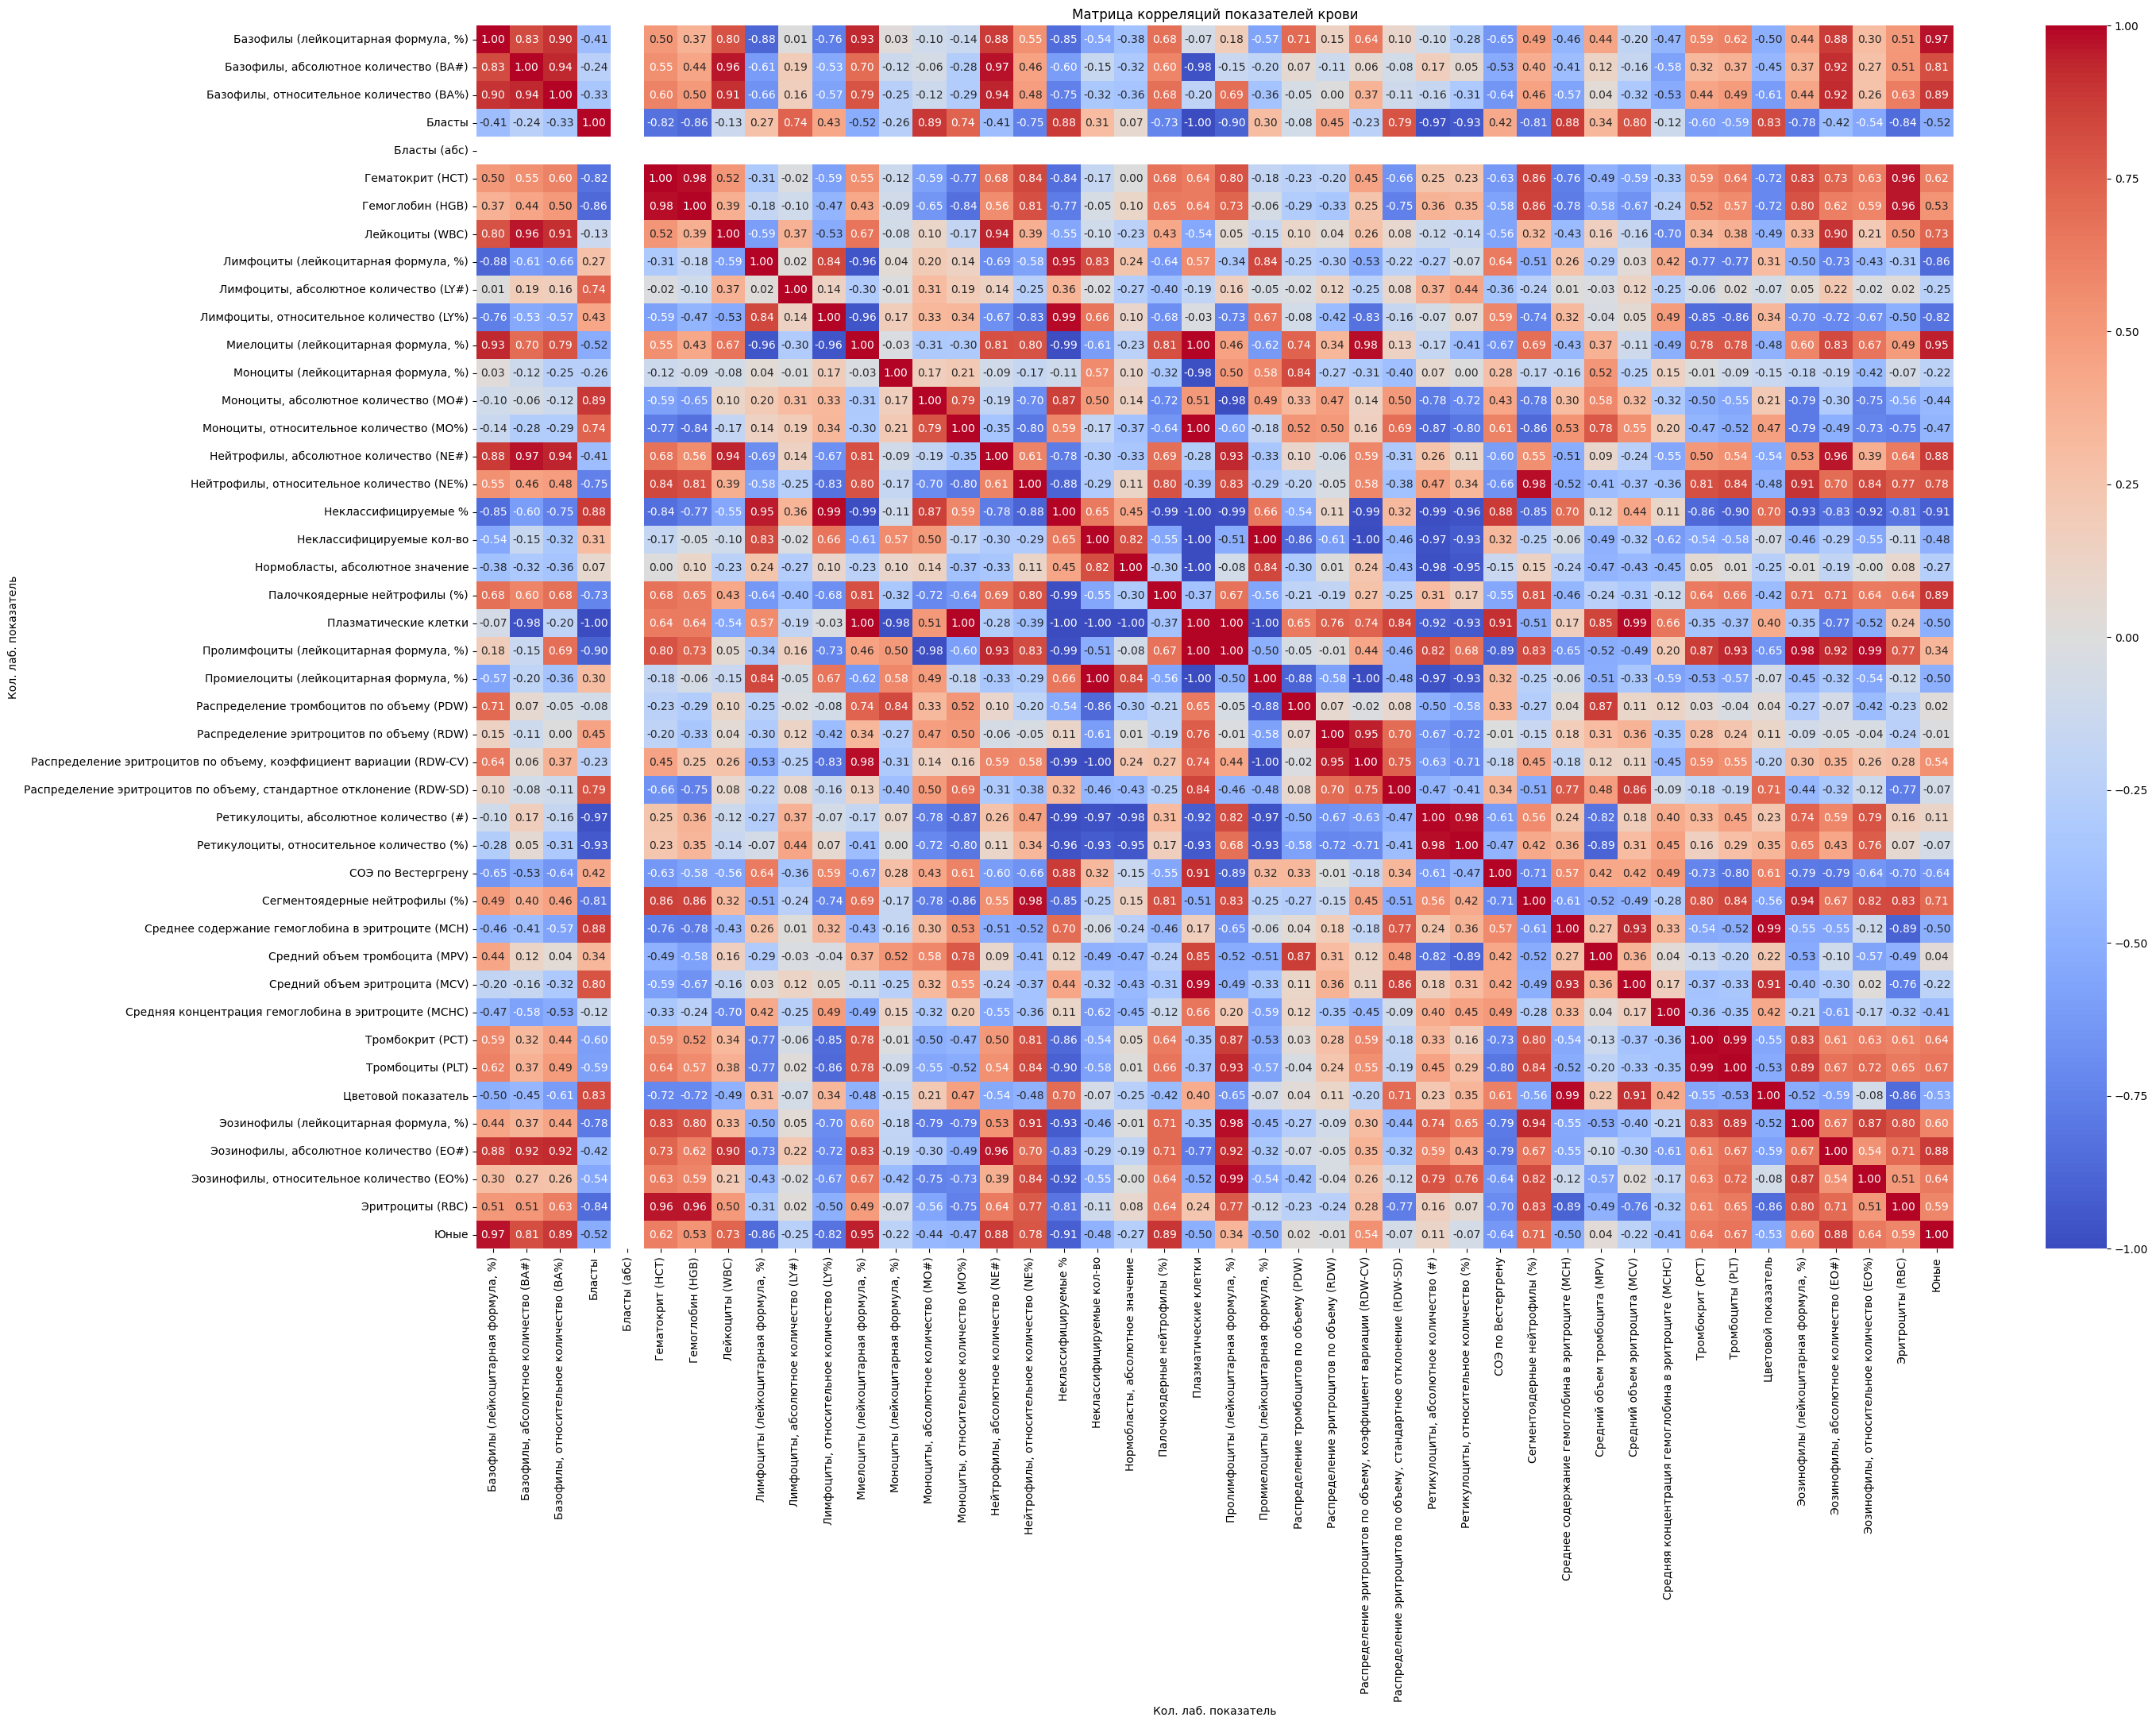

In [301]:
# Получиаем значения показателей крови по диагнозам
pivot_df = df_absolute.pivot_table(index='Осн. диаг. при выписке МКБ10 (текст)', columns='Кол. лаб. показатель', values='Значение кол. показателя', aggfunc='mean')

# Рассчитываем матрицу корреляций
correlation_matrix = pivot_df.corr()

# Создаем тепловую карту
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Матрица корреляций показателей крови')
plt.show()

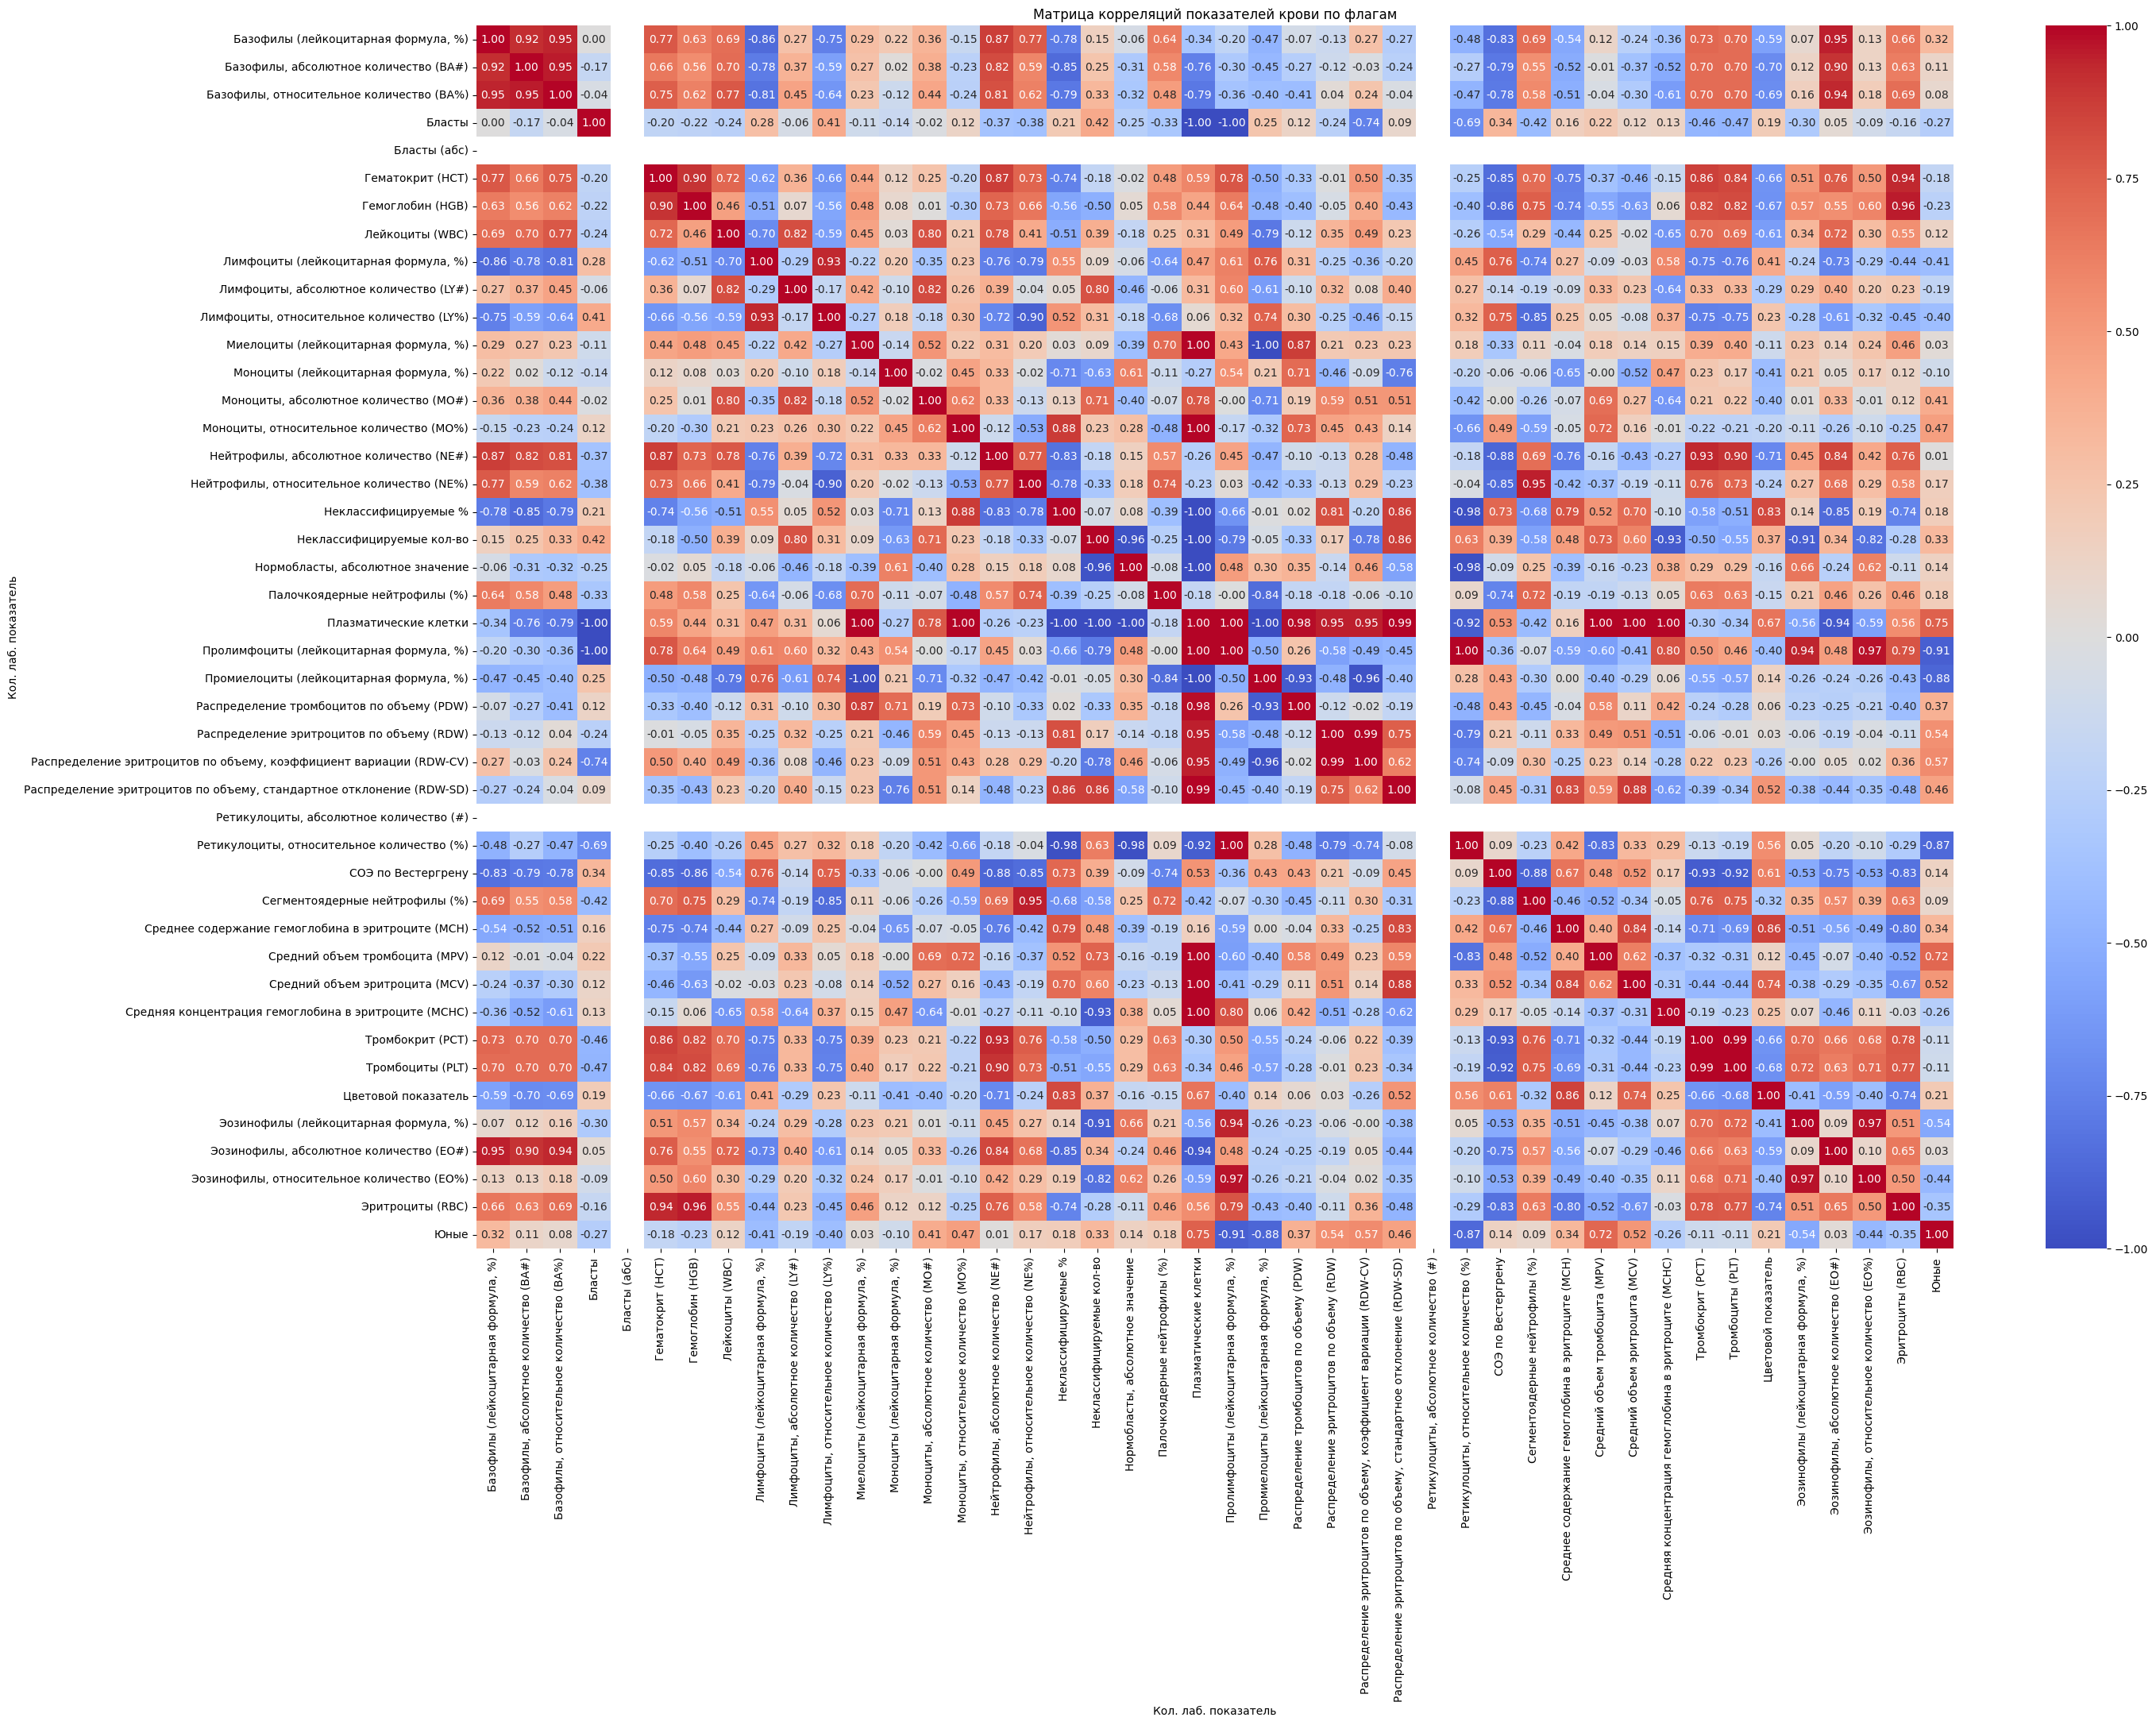

In [303]:
# Получиаем значения показателей крови по диагнозам
pivot_df2 = df_flags.pivot_table(index='Осн. диаг. при выписке МКБ10 (текст)', columns='Кол. лаб. показатель', values='Флаг нормы кол. показателя', aggfunc='mean')

# Рассчитываем матрицу корреляций
correlation_matrix2 = pivot_df2.corr()

# Создаем тепловую карту
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix2, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Матрица корреляций показателей крови по флагам')
plt.show()